In [ ]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import collections
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau

warnings.filterwarnings("ignore")

In [ ]:
# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

Device yang digunakan: cpu


In [ ]:
# ==========================
# 1. Persiapan Data
# ==========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

batch_size = 128

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=0, pin_memory=True) # num_workers diubah menjadi 0 dan pin_memory
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=0, pin_memory=True) # num_workers diubah menjadi 0 dan pin_memory

In [ ]:
# ==========================
# 2. Definisi Model CNN yang Fleksibel
# ==========================
class FlexibleCNN(nn.Module):
    def __init__(self, kernel_size, pooling_type):
        super(FlexibleCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=kernel_size, padding='same')
        self.relu1 = nn.ReLU()
        if pooling_type == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_type == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            raise ValueError("Pooling type harus 'max' atau 'avg'")

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, padding='same')
        self.relu2 = nn.ReLU()
        if pooling_type == 'max':
           self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pooling_type == 'avg':
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            raise ValueError("Pooling type harus 'max' atau 'avg'")

        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)

        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out

In [ ]:
# ==========================
# 3. Definisi Fungsi Training dengan Callback
# ==========================
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs, early_stopping_patience=10, learning_rate_scheduler=True):
    if learning_rate_scheduler:
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    best_test_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * images.size(0)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
          for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = 100 * correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        if learning_rate_scheduler:
          scheduler.step(epoch_test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

        if epoch_test_loss < best_test_loss:
          best_test_loss = epoch_test_loss
          early_stopping_counter = 0
          print("Validation Loss Improved")
        else:
          early_stopping_counter += 1
          print("Validation Loss Not Improved")

        if early_stopping_counter >= early_stopping_patience:
          print(f"Early stopping at epoch {epoch + 1}")
          break
    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
# ==========================
# 4. Definisi Hooks untuk Visualisasi (Dipindahkan)
# ==========================
def get_activation(name):
    def hook(model, input, output):
        activations[name].append(output.detach())
    return hook

def get_gradient(name):
    def hook(model, grad_input, grad_output):
        gradients[name].append(grad_output[0].detach())
    return hook

In [ ]:
# ==========================
# 5. Eksperimen dengan Berbagai Parameter
# ==========================
kernel_sizes = [3, 5] # kernel size dikurangi
pooling_types = ['max', 'avg']
epochs = [5, 50, 100] # epoch dikurangi
optimizers = ['adam'] # optimizer dikurangi
results = {}

for ks in kernel_sizes:
    for pool in pooling_types:
        for ep in epochs:
            for opt_name in optimizers:
                print(f"\nTraining Model: Kernel Size {ks}, Pooling {pool}, Epochs {ep}, Optimizer {opt_name}")
                model = FlexibleCNN(kernel_size=ks, pooling_type=pool).to(device)
                # Mendaftarkan hooks (Dipindahkan ke sini agar direset setiap eksperimen)
                # Pemindahan hook ke visualisasi per konfigurasi
                # hook tidak dipanggil disini


                criterion = nn.CrossEntropyLoss()

                if opt_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=0.01)
                elif opt_name == 'rmsprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.01)
                elif opt_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.001)
                else:
                    raise ValueError("Optimizer harus 'sgd', 'rmsprop' atau 'adam'")

                train_losses, test_losses, train_accuracies, test_accuracies = train_model(
                    model, train_loader, test_loader, optimizer, criterion, num_epochs=ep
                )

                results[(ks, pool, ep, opt_name)] = {
                    'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_accuracies': train_accuracies,
                    'test_accuracies': test_accuracies,
                    'model': model # simpan model untuk visualisasi
                }
                # reset activation dan gradient setelah training
                #visualisasi di lakukan di akhir training saja


                del model # hapus model
                torch.cuda.empty_cache() #hapus cache GPU


Training Model: Kernel Size 3, Pooling max, Epochs 5, Optimizer adam
Epoch [1/5], Train Loss: 0.2277, Train Acc: 93.31%, Test Loss: 0.0615, Test Acc: 98.17%
Validation Loss Improved
Epoch [2/5], Train Loss: 0.0641, Train Acc: 98.01%, Test Loss: 0.0669, Test Acc: 97.83%
Validation Loss Not Improved
Epoch [3/5], Train Loss: 0.0467, Train Acc: 98.53%, Test Loss: 0.0406, Test Acc: 98.76%
Validation Loss Improved
Epoch [4/5], Train Loss: 0.0375, Train Acc: 98.83%, Test Loss: 0.0353, Test Acc: 98.83%
Validation Loss Improved
Epoch [5/5], Train Loss: 0.0287, Train Acc: 99.11%, Test Loss: 0.0368, Test Acc: 98.79%
Validation Loss Not Improved

Training Model: Kernel Size 3, Pooling max, Epochs 50, Optimizer adam
Epoch [1/50], Train Loss: 0.2514, Train Acc: 92.57%, Test Loss: 0.0620, Test Acc: 98.11%
Validation Loss Improved
Epoch [2/50], Train Loss: 0.0629, Train Acc: 98.06%, Test Loss: 0.0485, Test Acc: 98.44%
Validation Loss Improved
Epoch [3/50], Train Loss: 0.0445, Train Acc: 98.60%, Test 

In [ ]:
# ==========================
# 6. Fungsi Evaluasi dan Visualisasi (Modifikasi)
# ==========================
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in range(10)],
                yticklabels=[str(i) for i in range(10)])
    plt.xlabel('Prediksi')
    plt.ylabel('Label Sebenarnya')
    plt.title('Confusion Matrix')
    plt.show()

def show_predictions(model, test_loader, device):
    model.eval()
    examples = 3
    with torch.no_grad():
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        images = images.cpu().numpy()

        plt.figure(figsize=(10, 2))
        for idx in range(examples):
            plt.subplot(1, examples, idx + 1)
            plt.imshow(np.squeeze(images[idx]), cmap='gray')
            plt.title(f"Pred: {predicted[idx].item()}")
            plt.axis('off')
        plt.show()

def plot_activation_distribution(activations, layer_name):
    if layer_name in activations:
        act = activations[layer_name][-1].cpu().numpy()
        act = act.flatten()
        plt.figure(figsize=(6, 4))
        sns.histplot(act, bins=50, kde=True)
        plt.title(f'Distribusi Aktivasi - {layer_name}')
        plt.xlabel('Aktivasi')
        plt.ylabel('Frekuensi')
        plt.show()

def plot_gradient_flow(gradients, layer_names):
    ave_grads = []
    max_grads = []
    for layer in layer_names:
        if layer in gradients:
            grads = gradients[layer]
            ave_grads.append(torch.mean(torch.stack([g.abs().mean() for g in grads])).item())
            max_grads.append(torch.stack([g.abs().max() for g in grads]).mean().item())

    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(layer_names)), ave_grads, alpha=0.5, label='Ave. Grad')
    plt.bar(np.arange(len(layer_names)), max_grads, alpha=0.5, label='Max Grad')
    plt.hlines(0, 0, len(layer_names) + 1, linewidth=1, color="k")
    plt.xticks(range(len(layer_names)), layer_names, rotation=45)
    plt.xlabel('Lapisan')
    plt.ylabel('Gradien')
    plt.title('Aliran Gradien')
    plt.legend()
    plt.show()

def plot_gradient_norm(gradients, layer_names):
    norm_grads = []
    for layer in layer_names:
        if layer in gradients:
            grads = gradients[layer]
            norm = torch.stack([g.norm() for g in grads]).mean().item()
            norm_grads.append(norm)

    plt.figure(figsize=(10, 5))
    plt.plot(layer_names, norm_grads, 'o-')
    plt.title('Norm Gradien per Lapisan')
    plt.xlabel('Lapisan')
    plt.ylabel('Norm Gradien')
    plt.xticks(rotation=45)
    plt.show()


def plot_saliency_map(model, image, label, device):
    image = image.to(device)
    image.requires_grad = True

    model.eval()
    output = model(image.unsqueeze(0))
    loss = criterion(output, torch.tensor([label]).to(device))
    model.zero_grad()
    loss.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=0)
    saliency = saliency.cpu().numpy()

    plt.figure(figsize=(3, 3))
    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')
    plt.show()

def plot_weight_distribution(model, layer_names):
    for name, layer in model.named_modules():
        if name in layer_names and (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)):
            weights = layer.weight.data.cpu().numpy().flatten()
            plt.figure(figsize=(6, 4))
            sns.histplot(weights, bins=50, kde=True)
            plt.title(f'Distribusi Bobot - {name}')
            plt.xlabel('Bobot')
            plt.ylabel('Frekuensi')
            plt.show()


Visualisasi Hasil: Kernel Size 3, Pooling max, Epochs 5, Optimizer adam


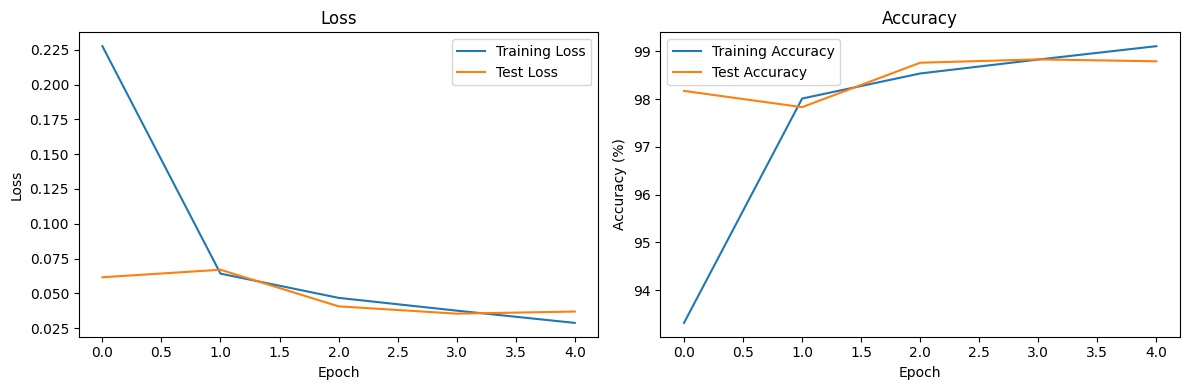

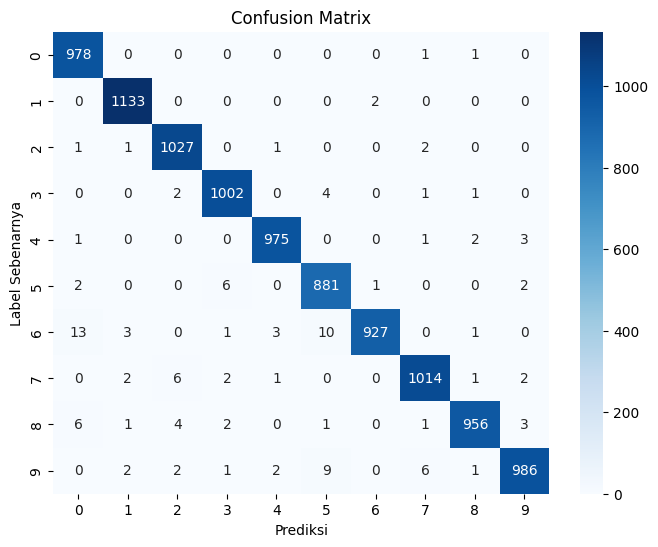

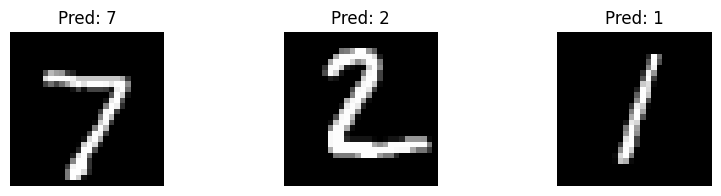

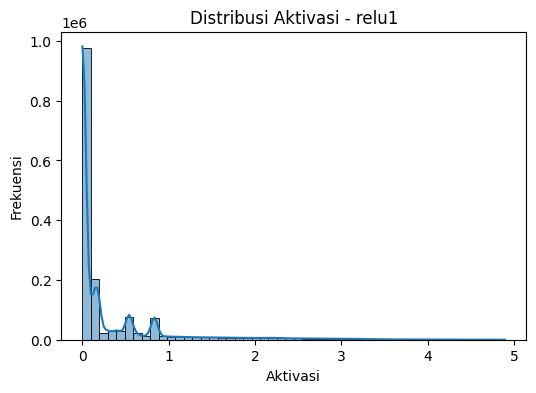

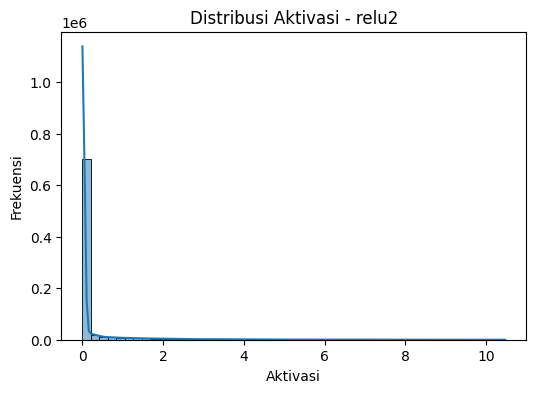

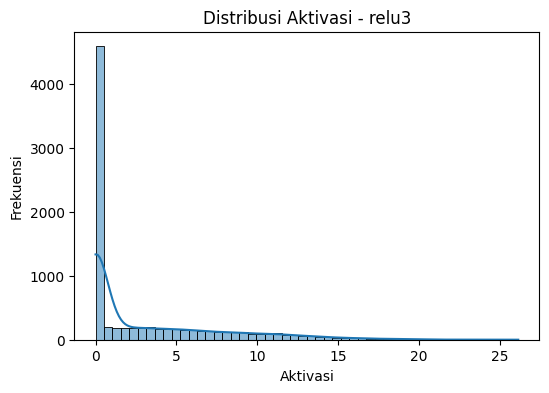

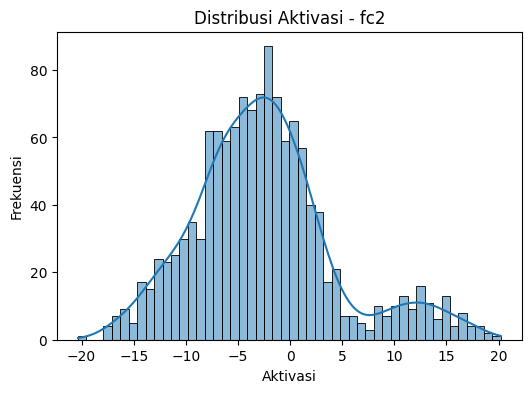

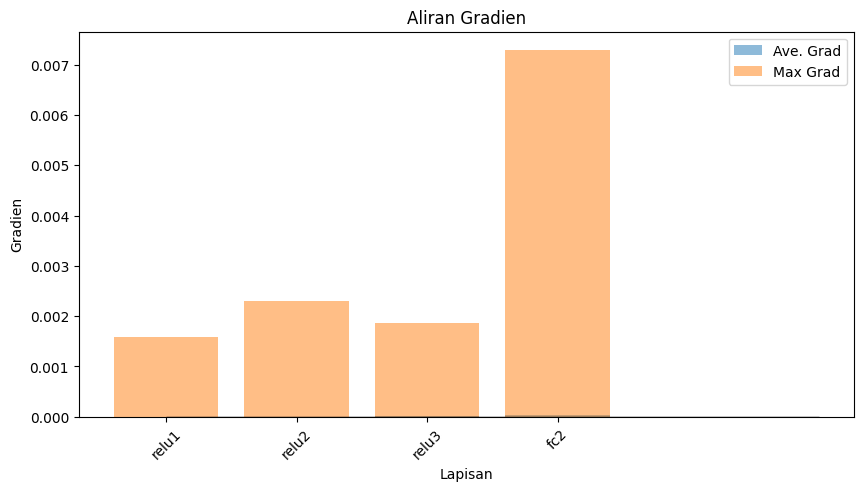

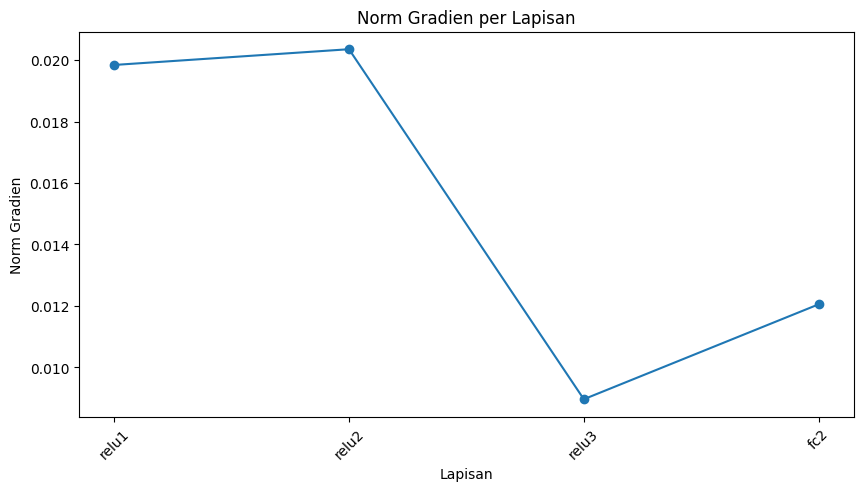

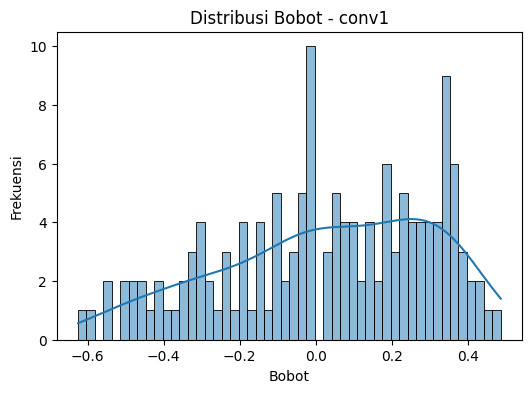

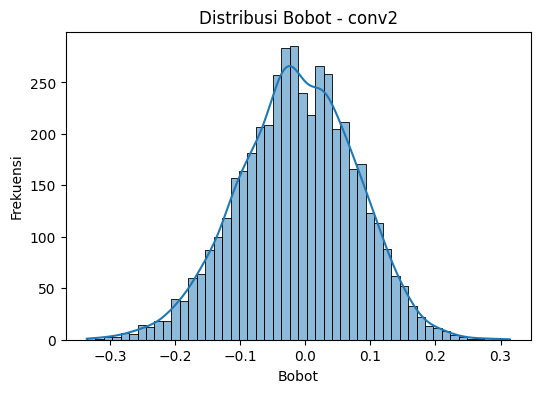

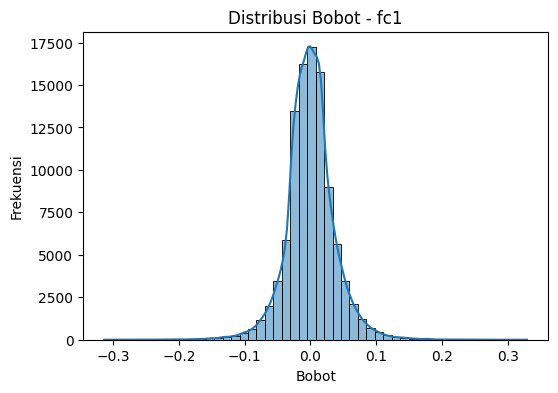

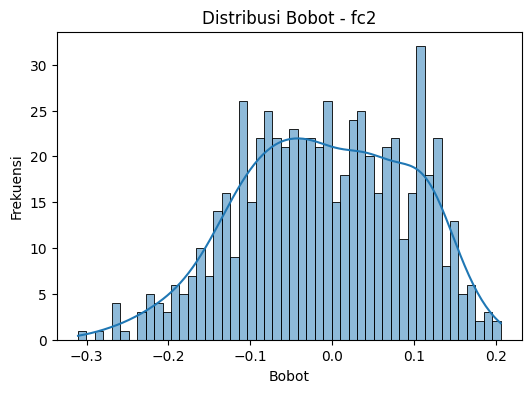

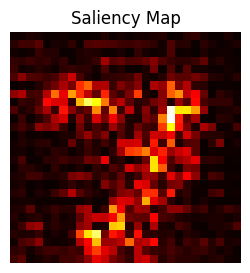


Visualisasi Hasil: Kernel Size 3, Pooling max, Epochs 50, Optimizer adam


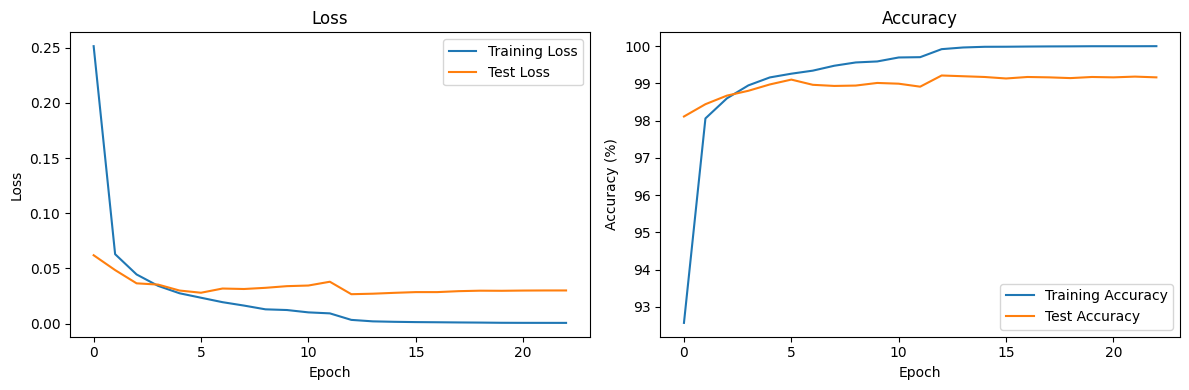

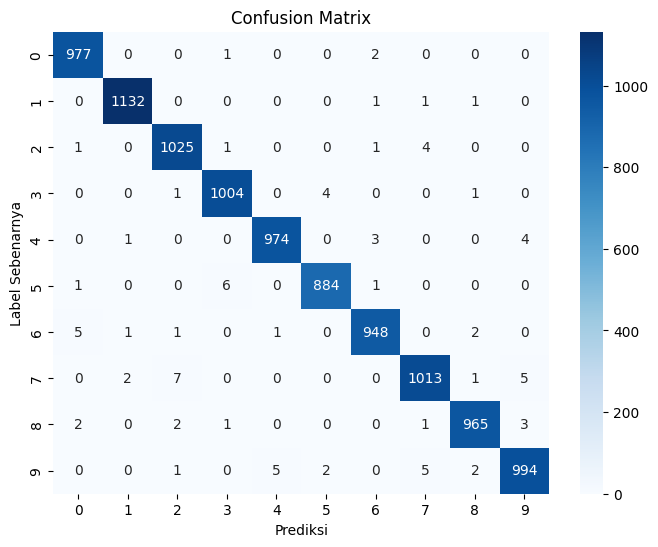

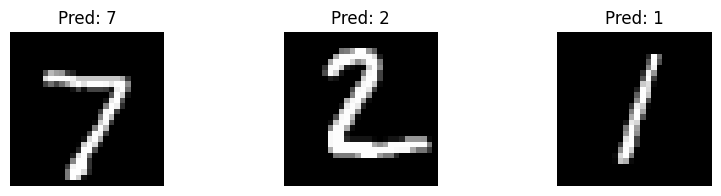

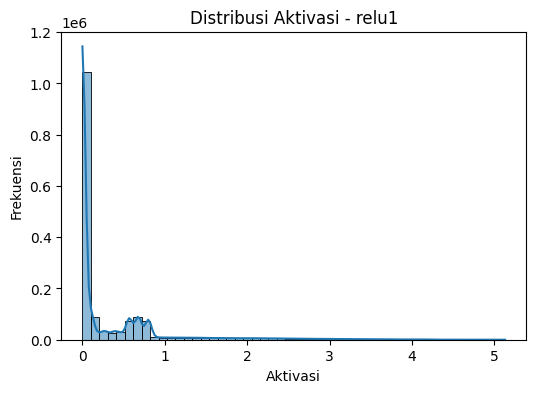

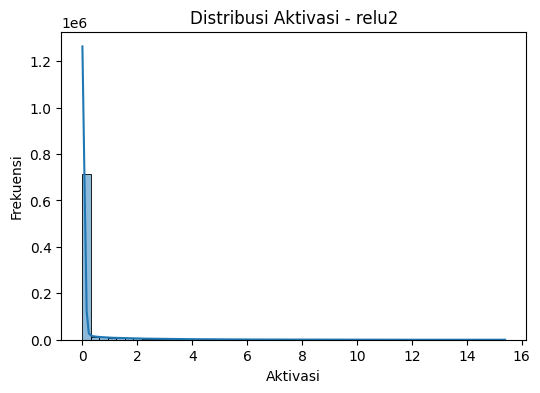

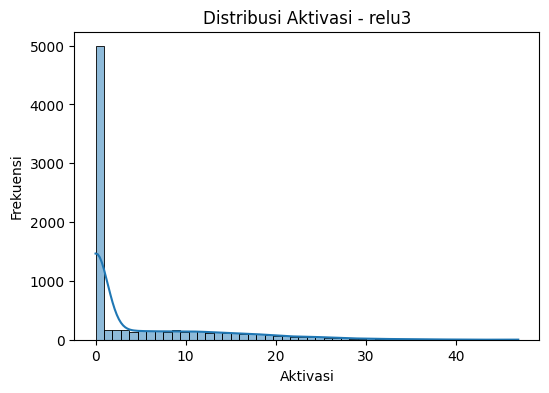

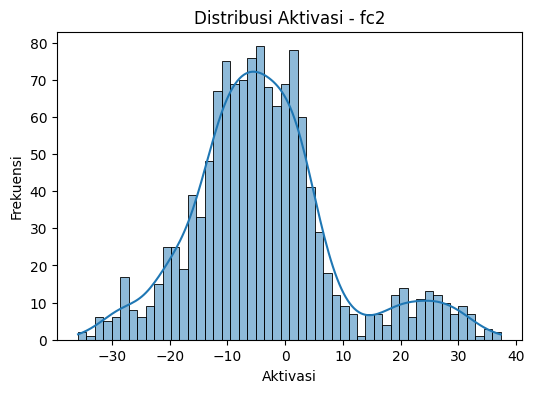

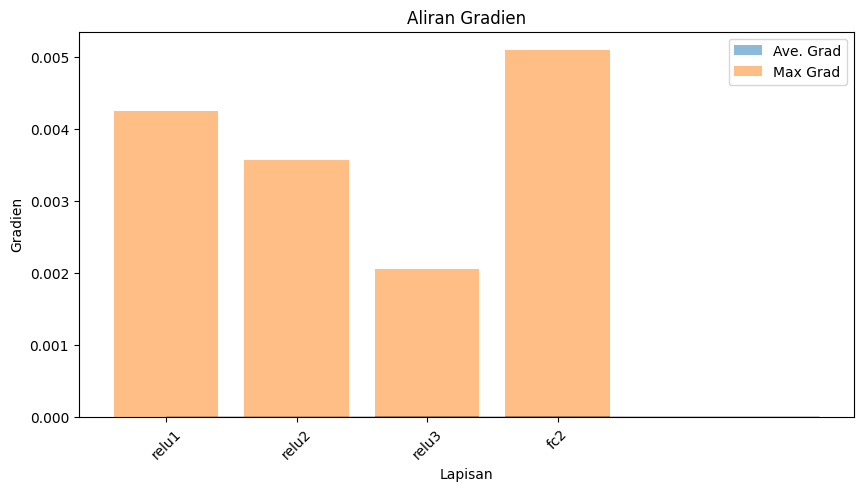

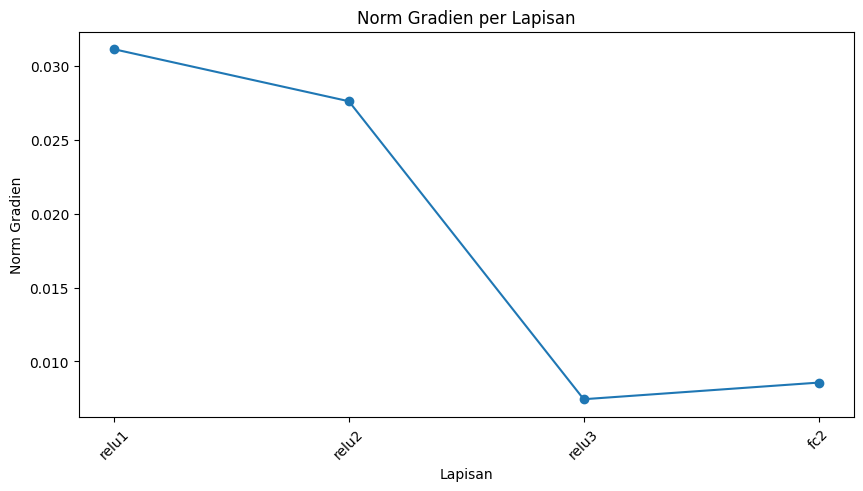

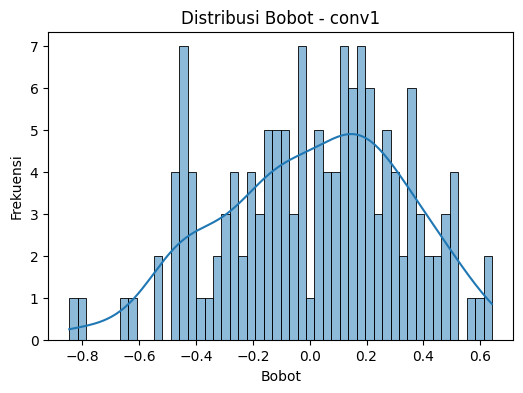

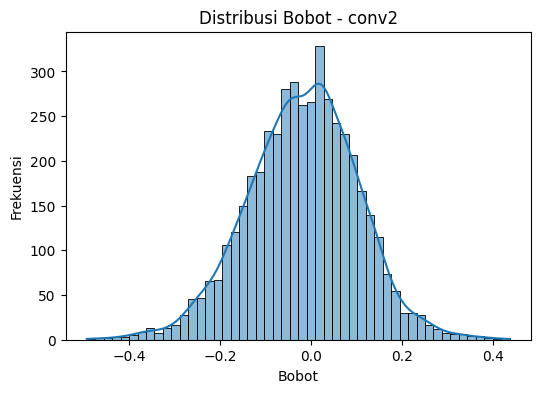

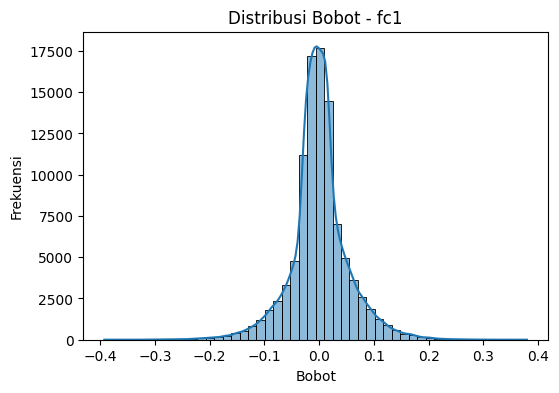

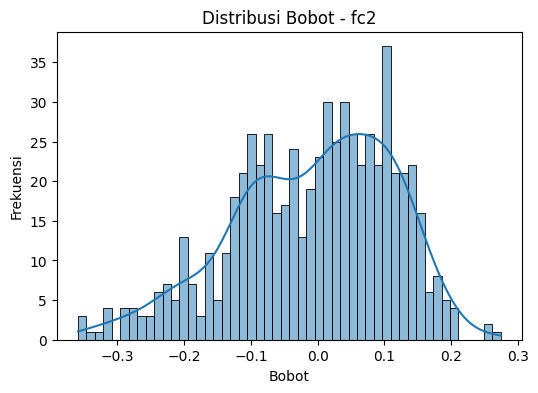

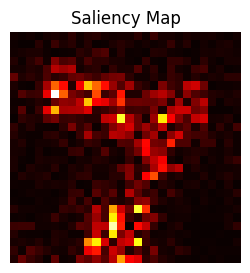


Visualisasi Hasil: Kernel Size 3, Pooling max, Epochs 100, Optimizer adam


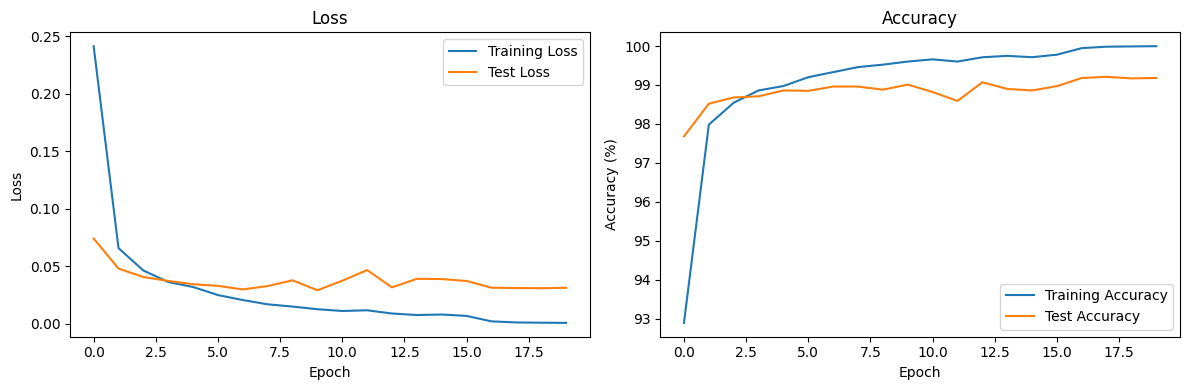

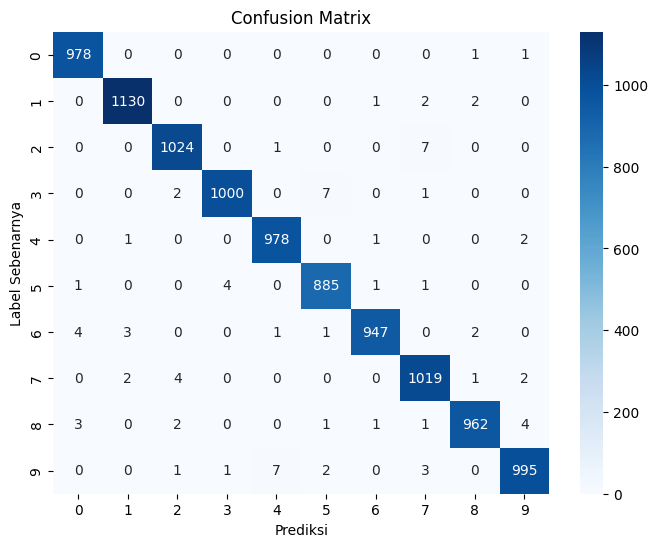

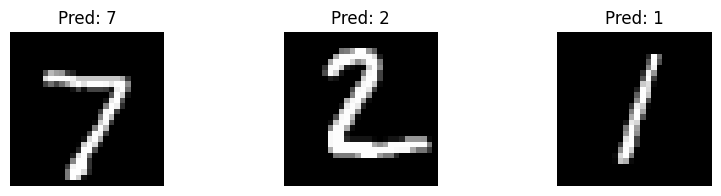

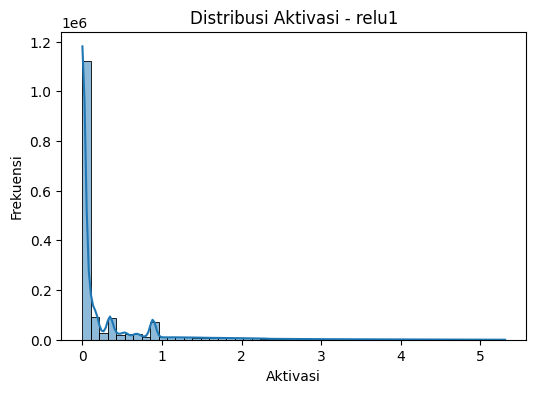

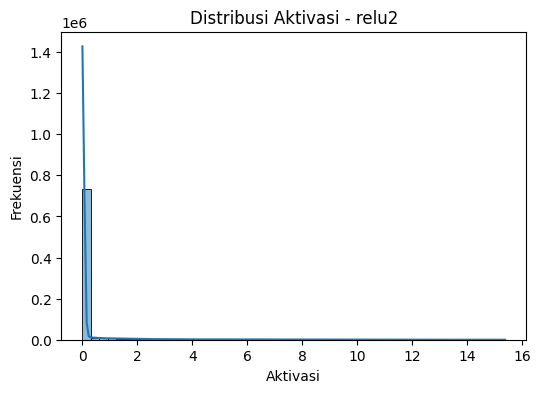

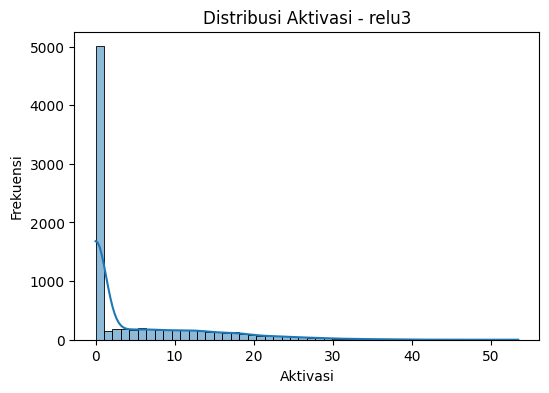

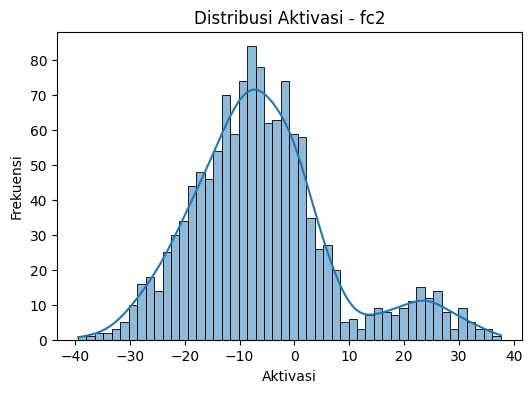

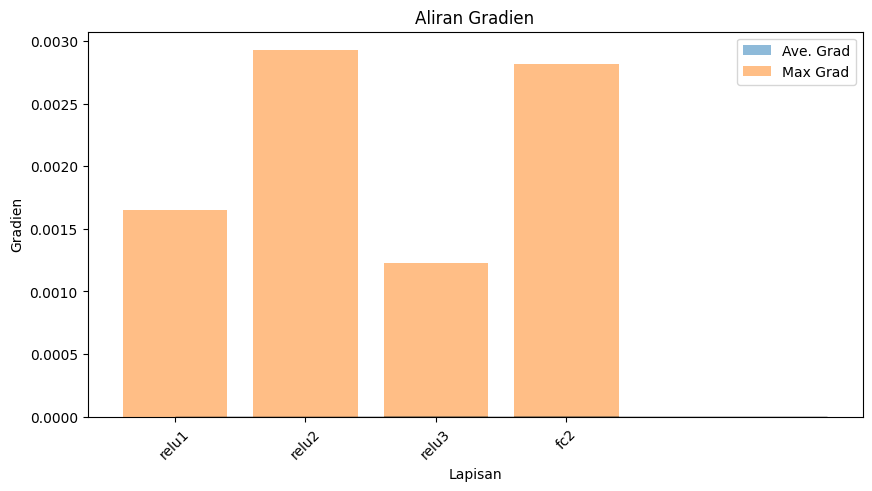

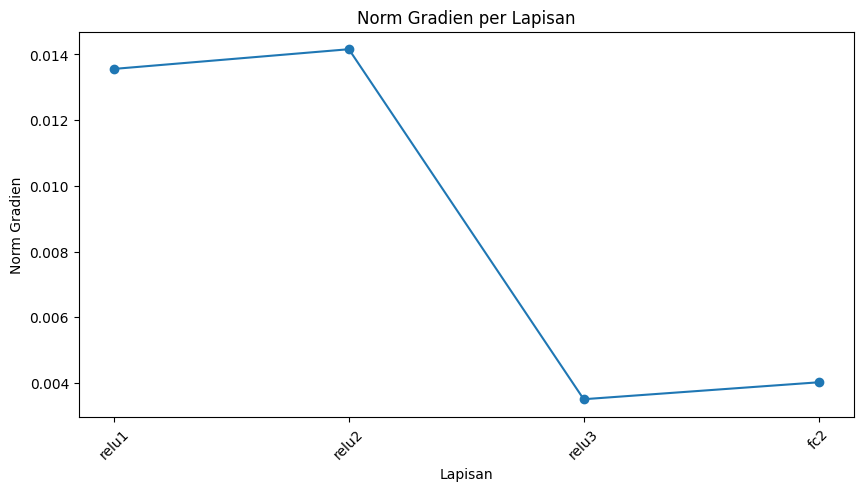

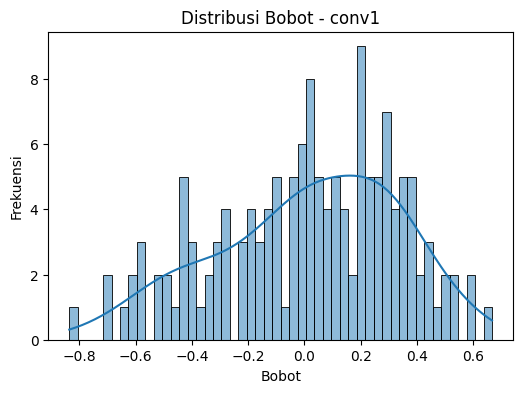

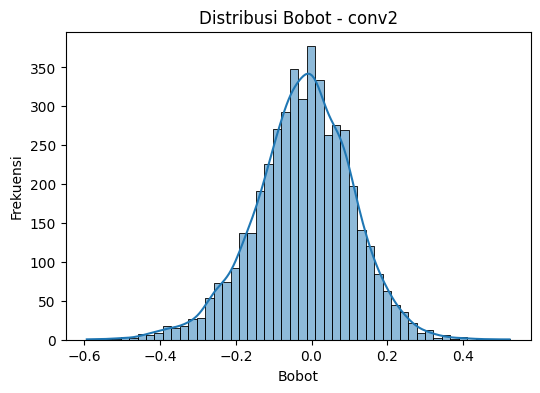

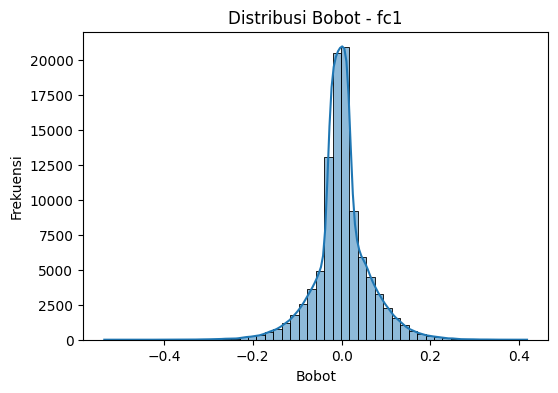

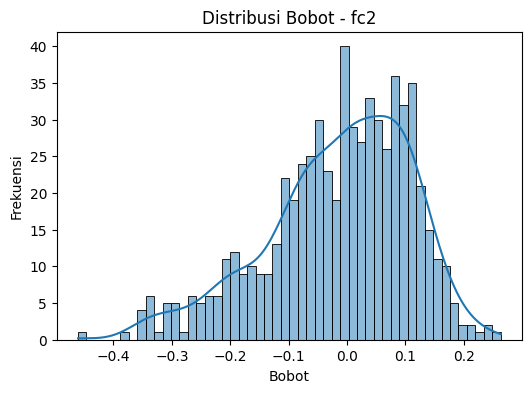

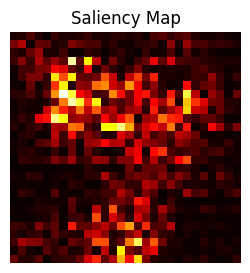


Visualisasi Hasil: Kernel Size 3, Pooling avg, Epochs 5, Optimizer adam


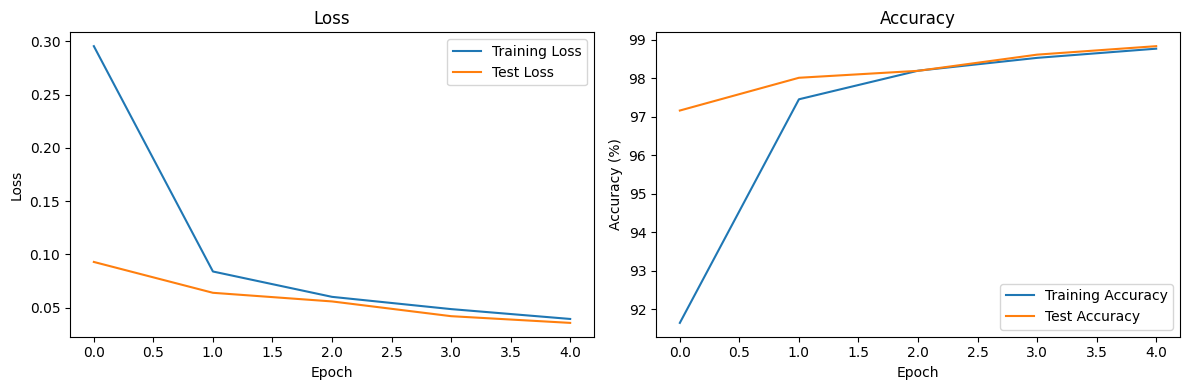

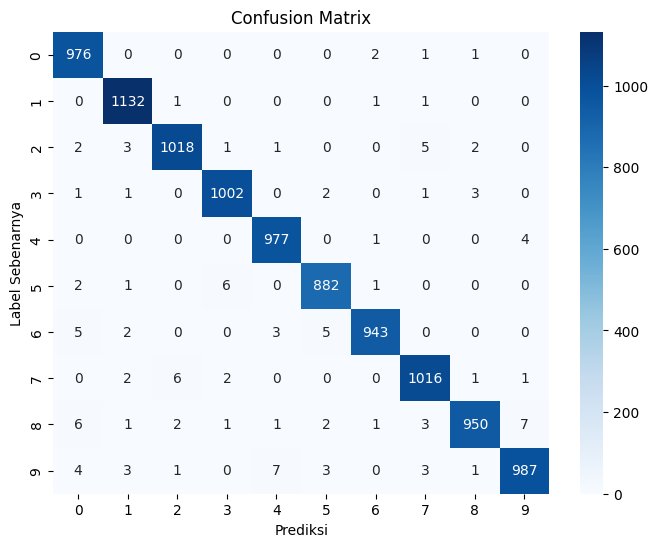

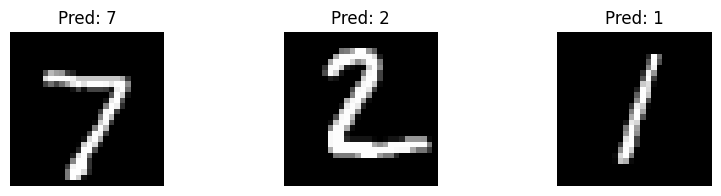

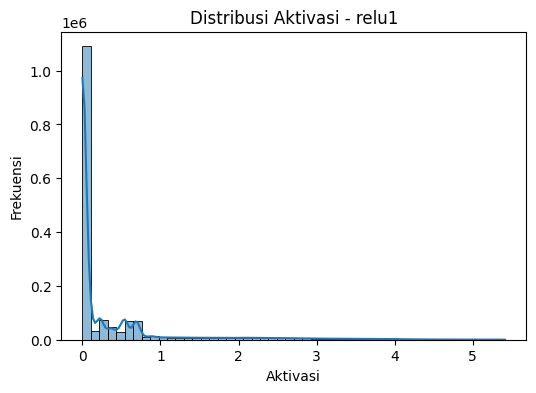

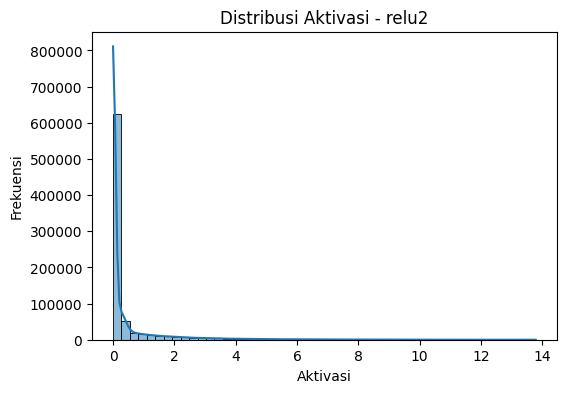

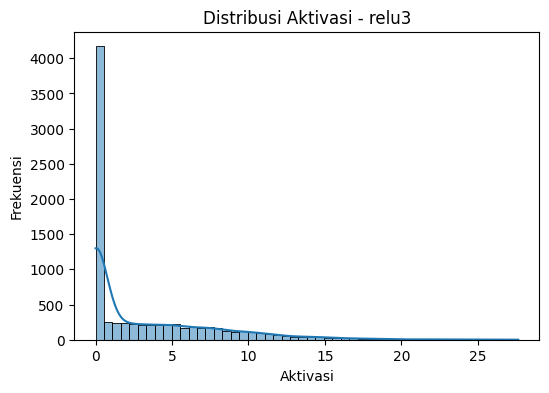

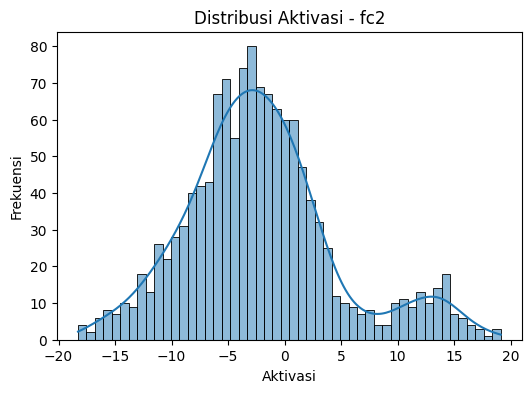

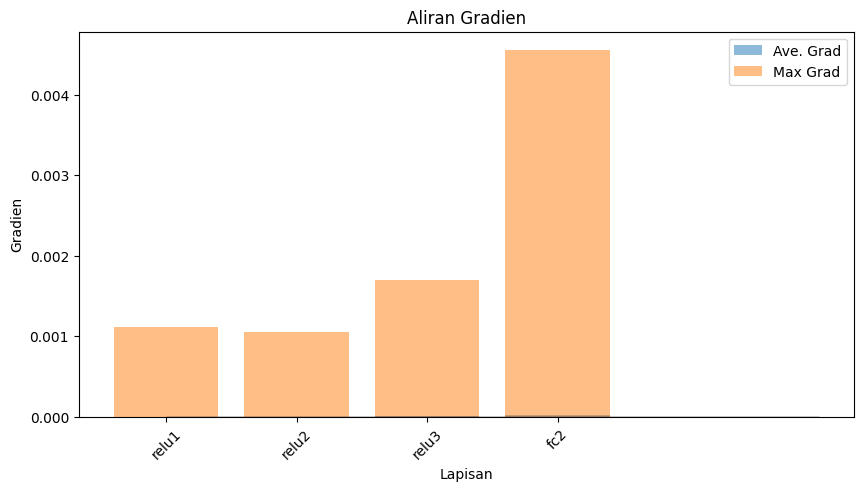

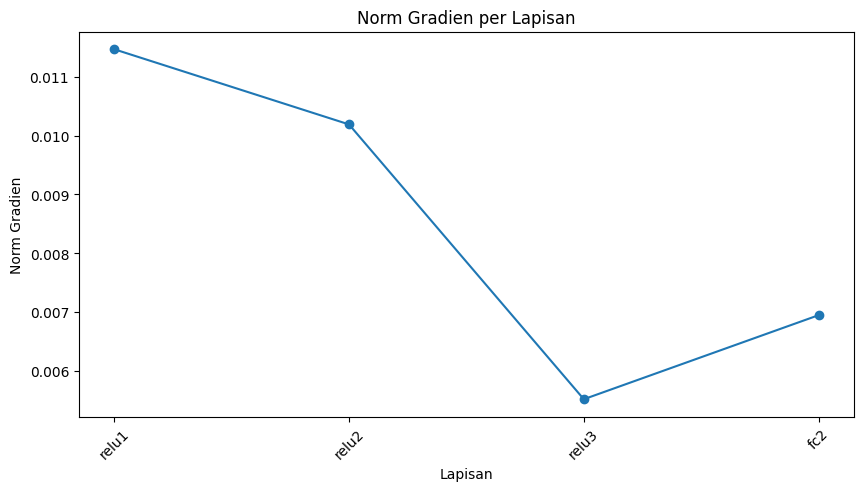

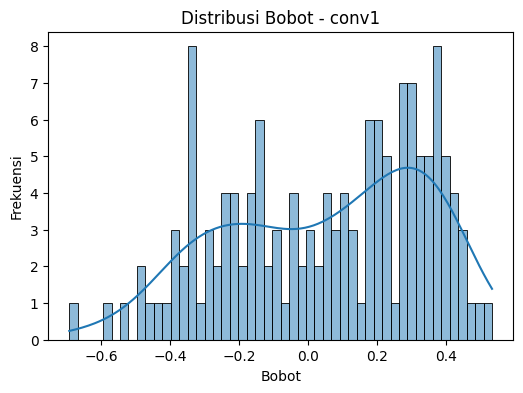

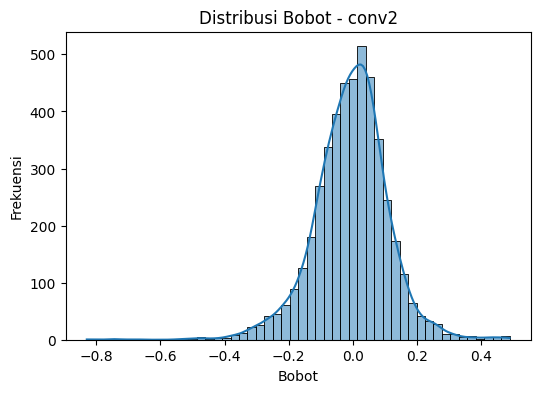

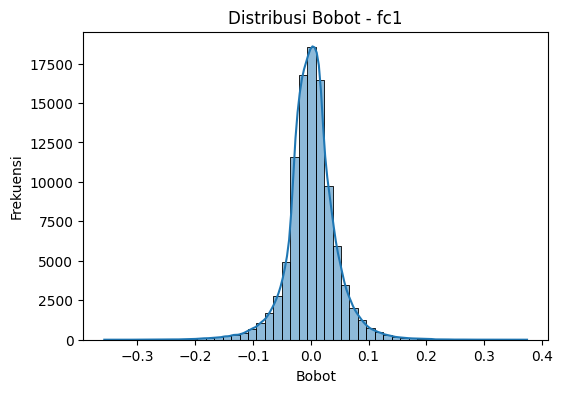

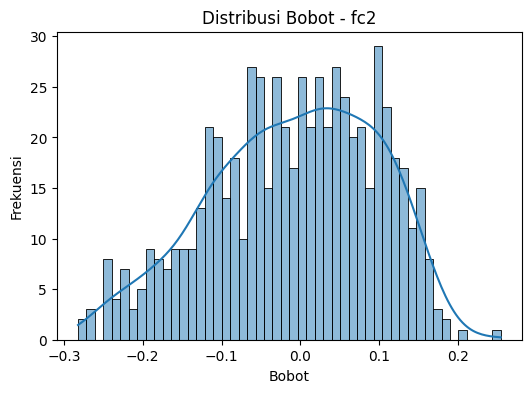

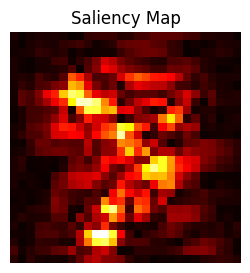


Visualisasi Hasil: Kernel Size 3, Pooling avg, Epochs 50, Optimizer adam


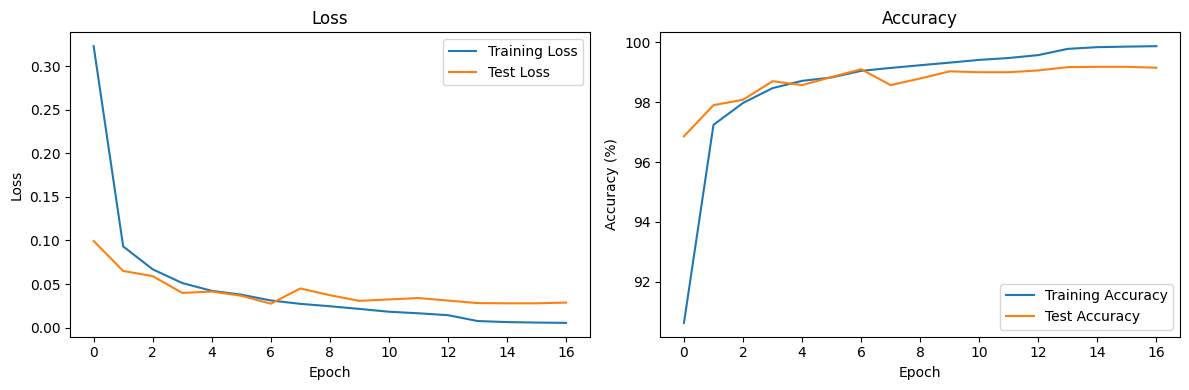

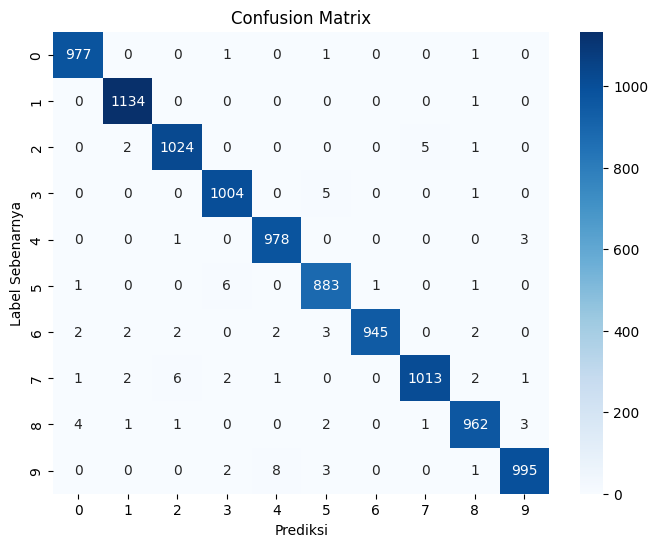

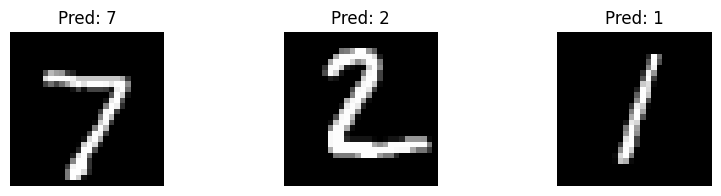

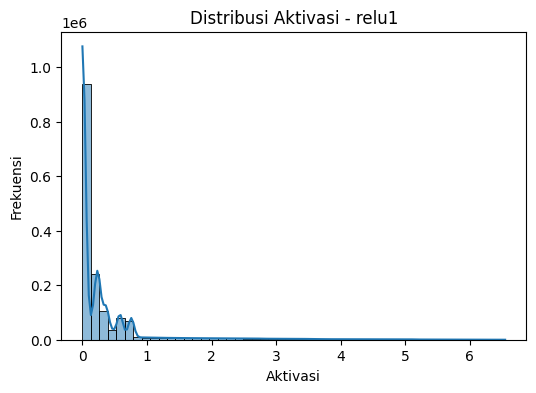

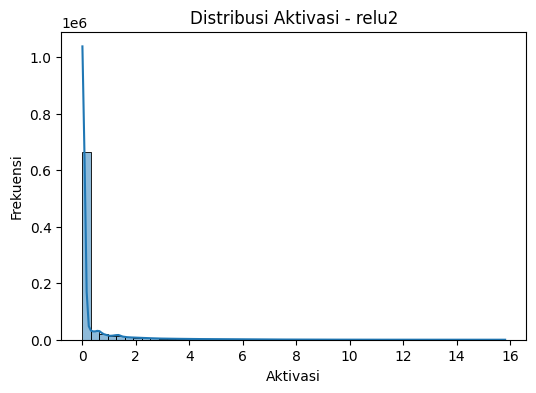

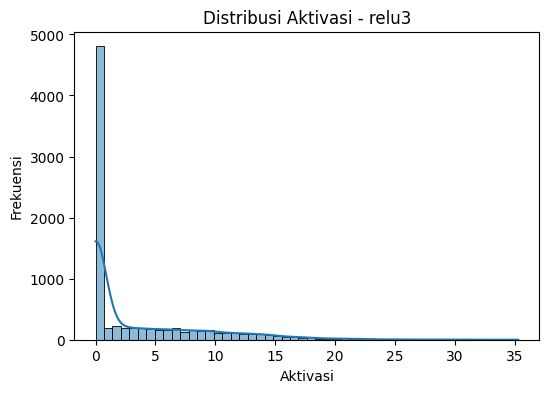

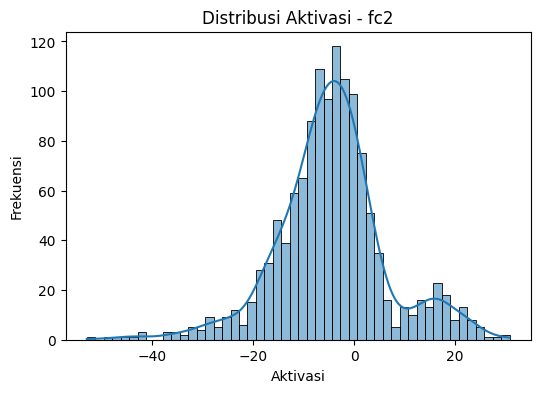

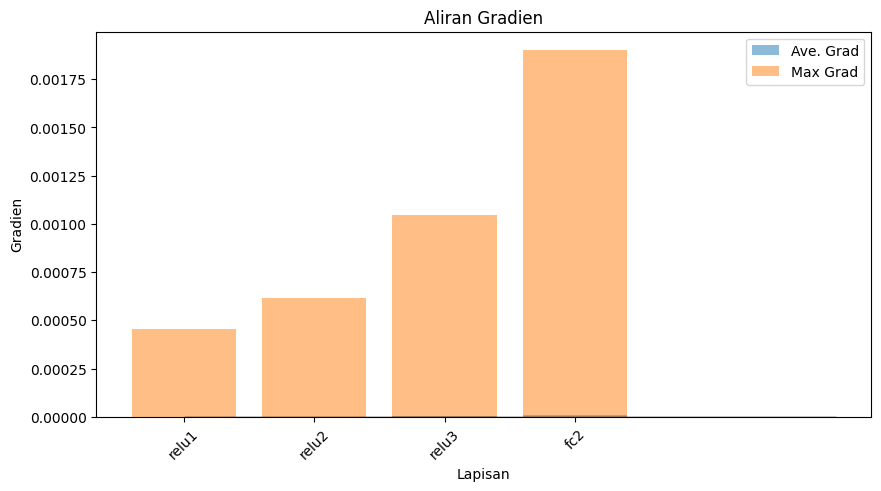

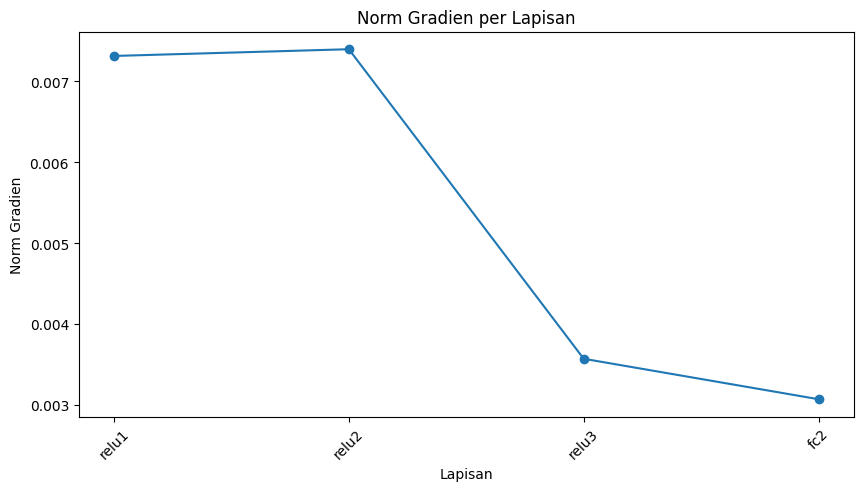

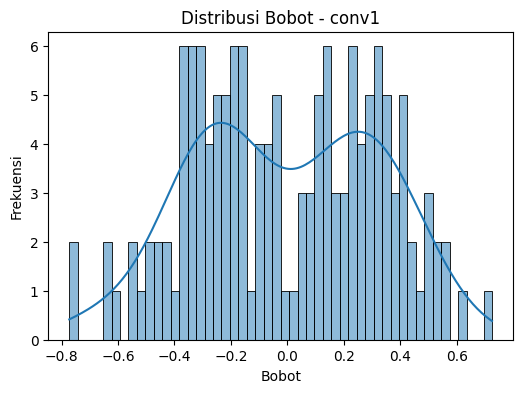

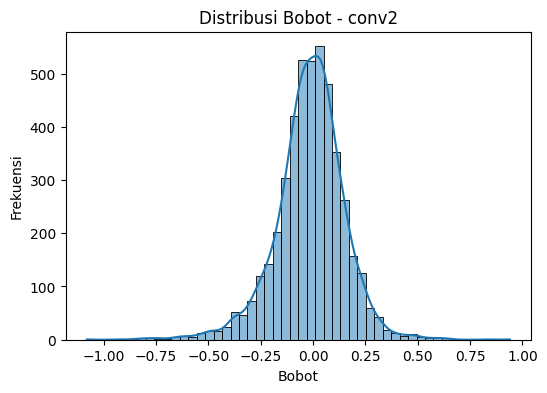

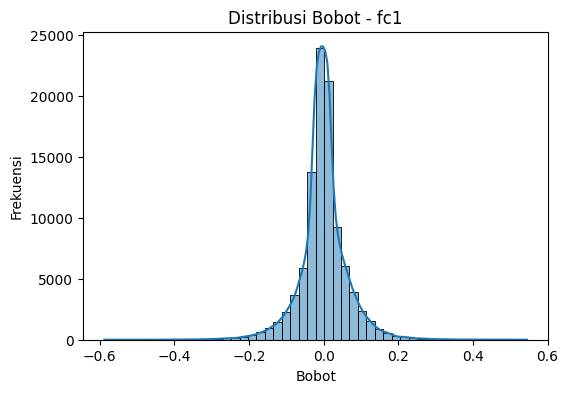

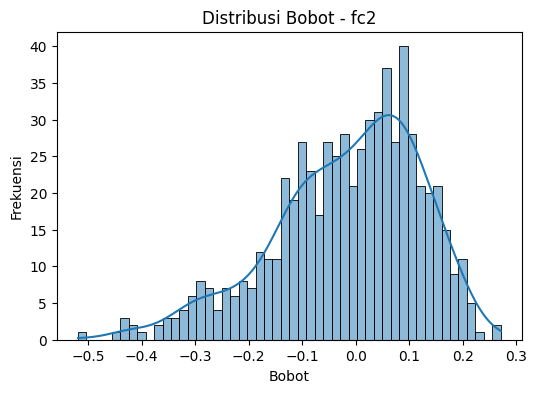

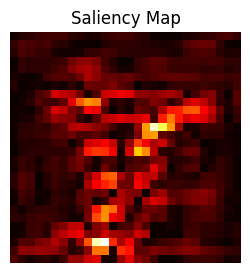


Visualisasi Hasil: Kernel Size 3, Pooling avg, Epochs 100, Optimizer adam


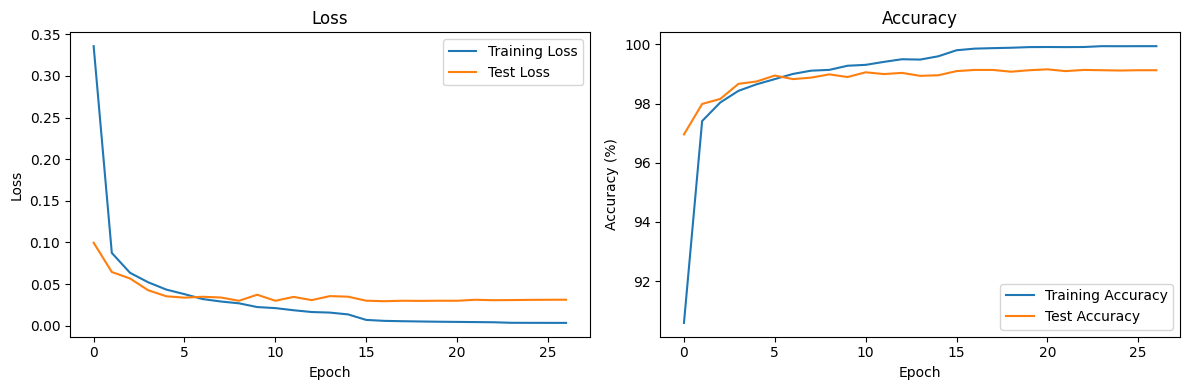

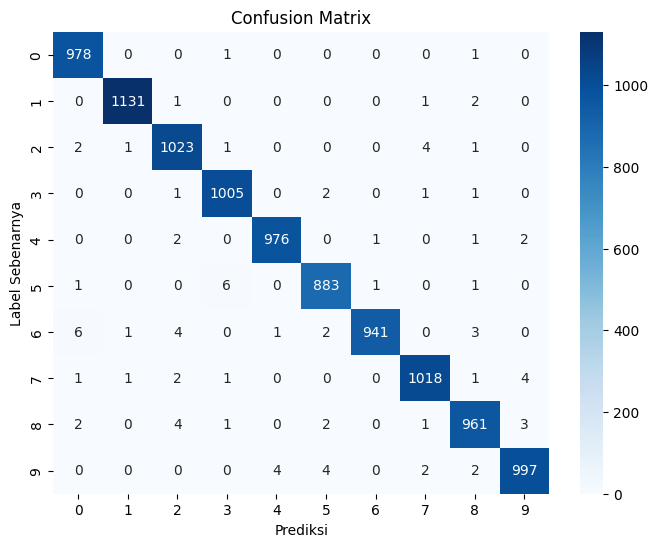

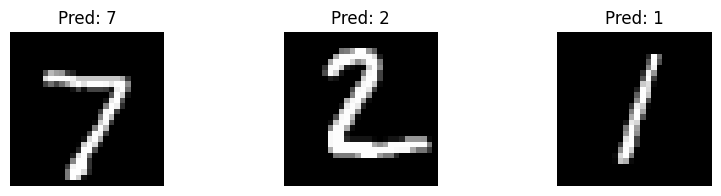

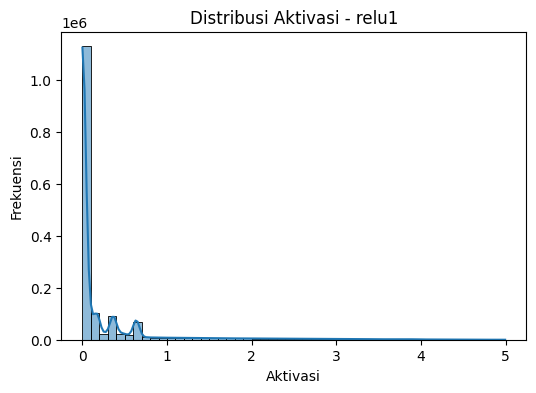

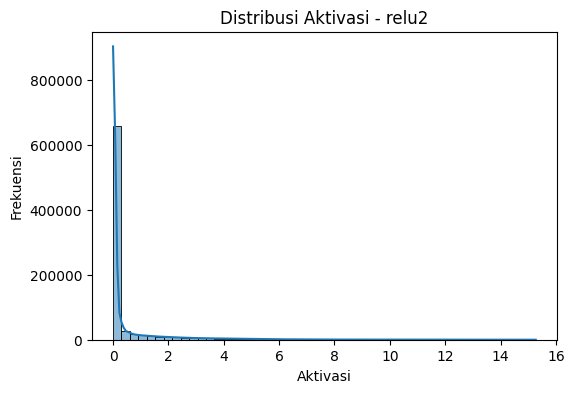

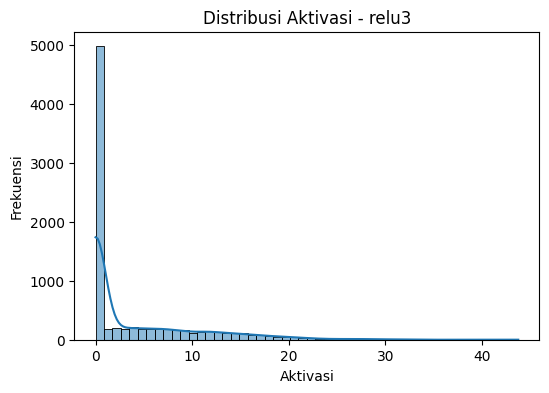

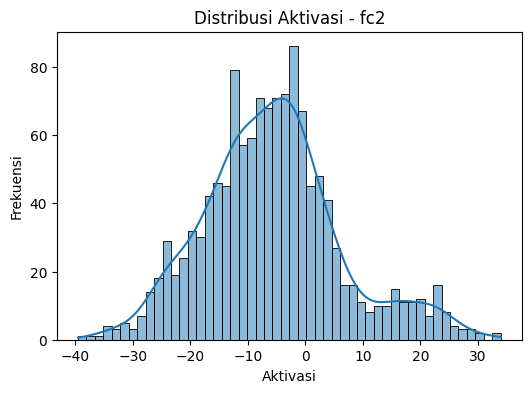

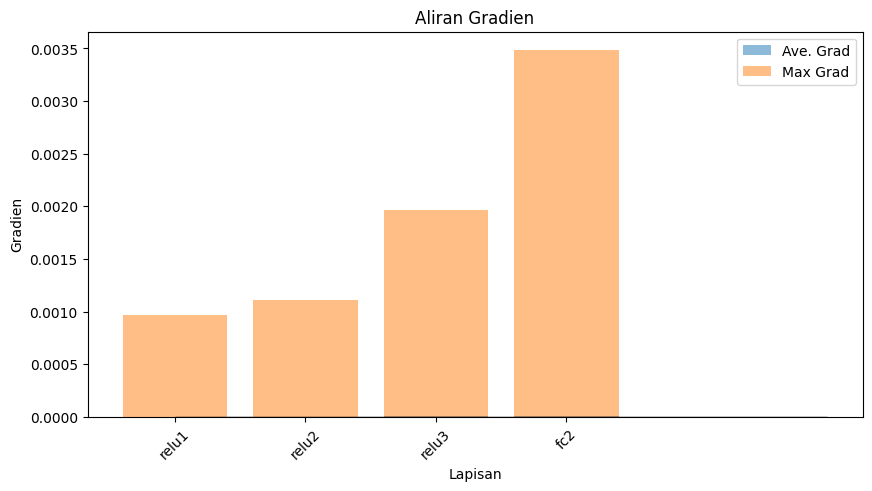

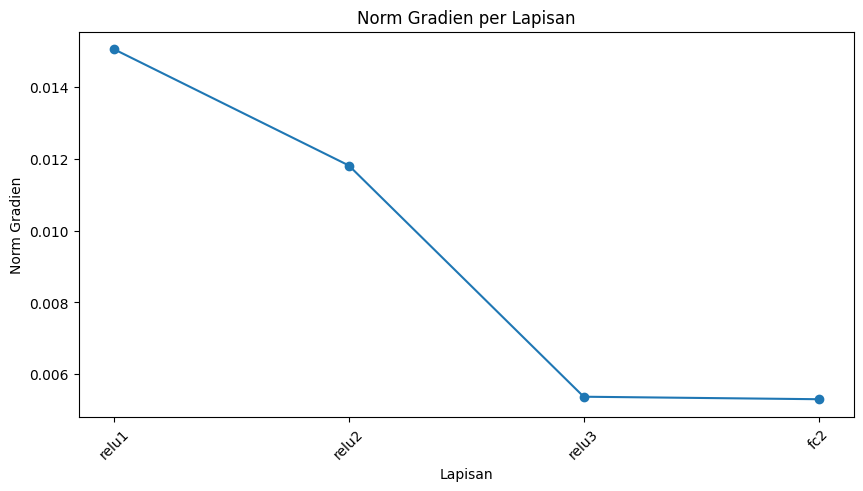

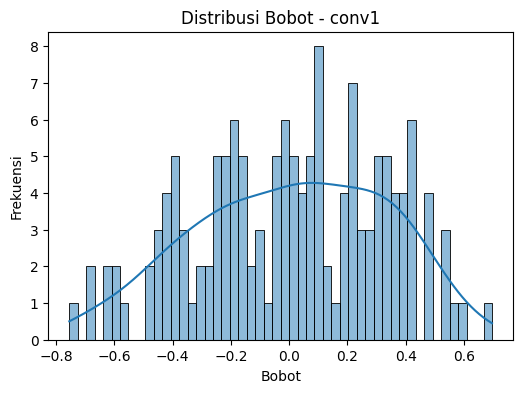

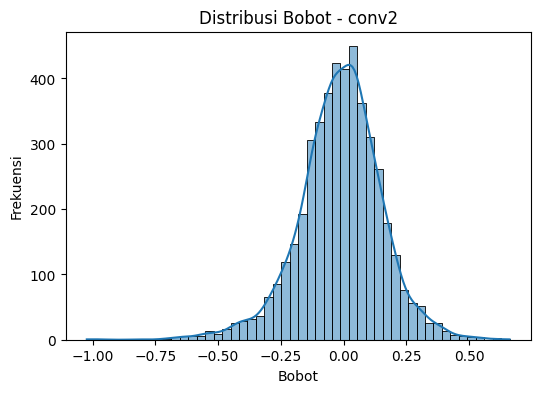

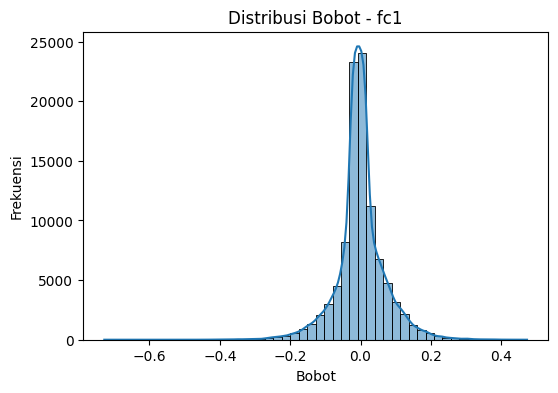

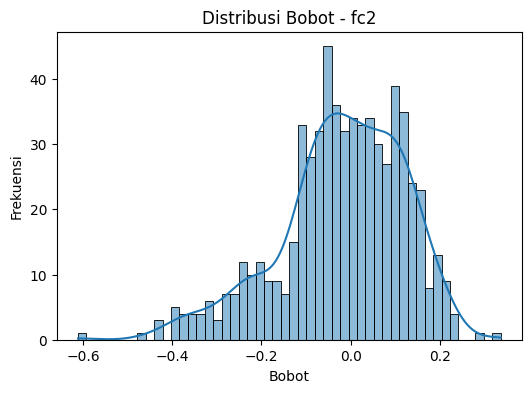

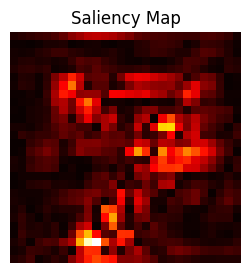


Visualisasi Hasil: Kernel Size 5, Pooling max, Epochs 5, Optimizer adam


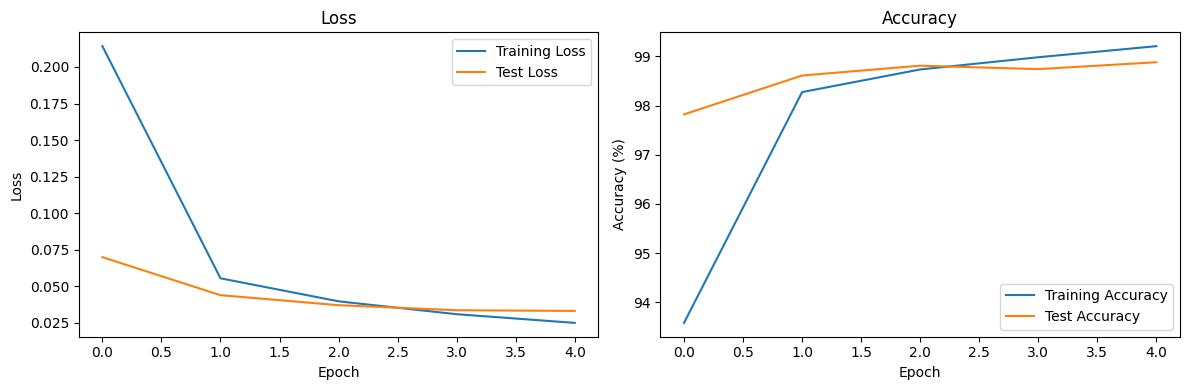

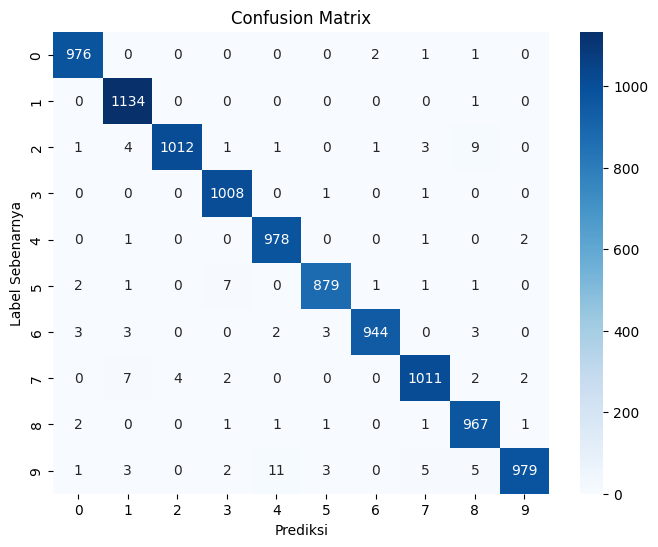

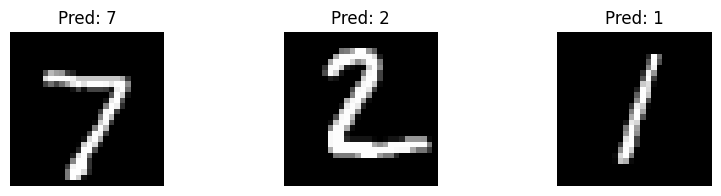

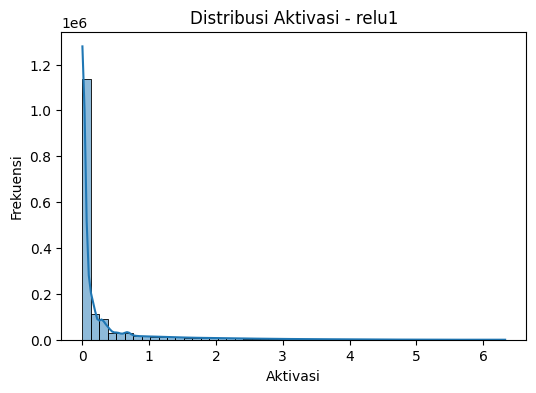

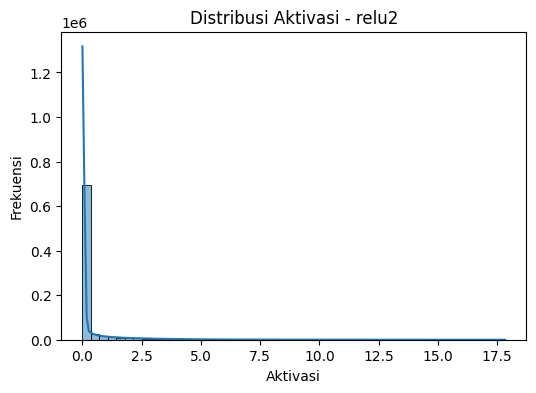

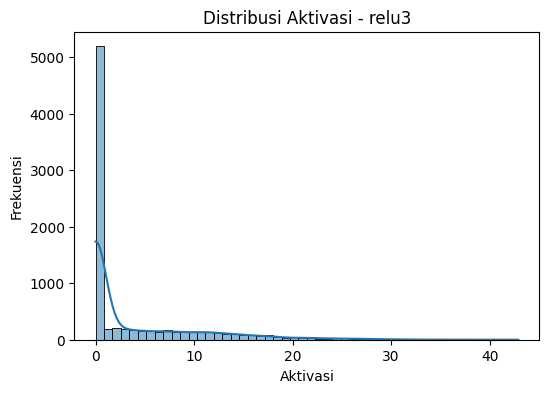

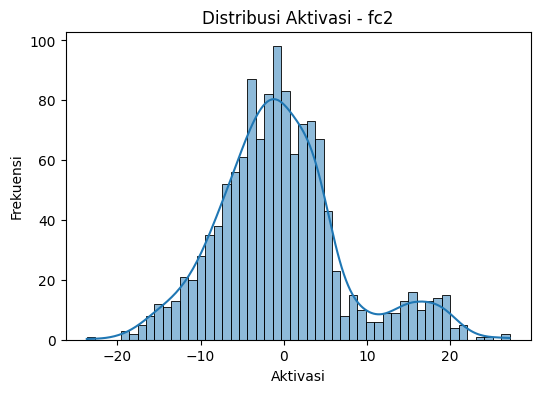

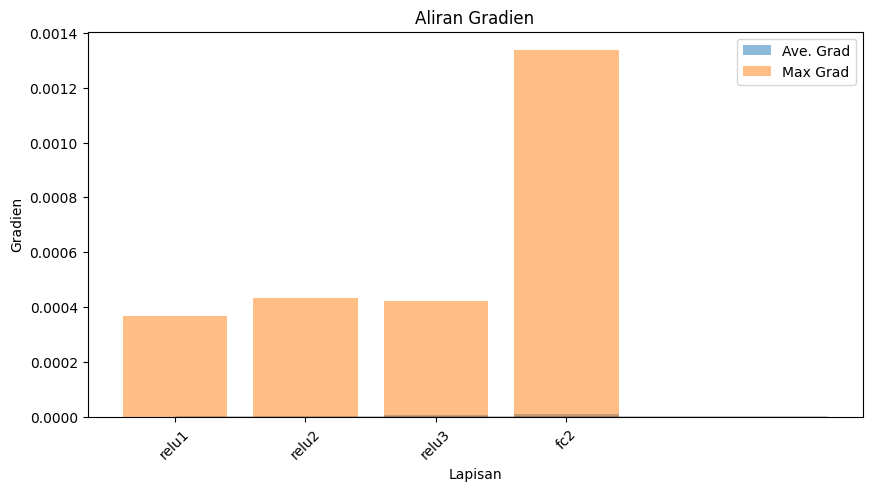

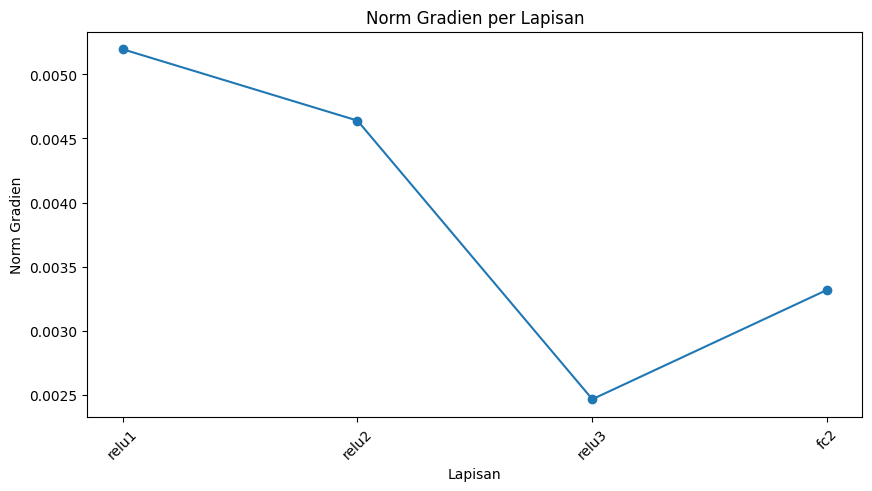

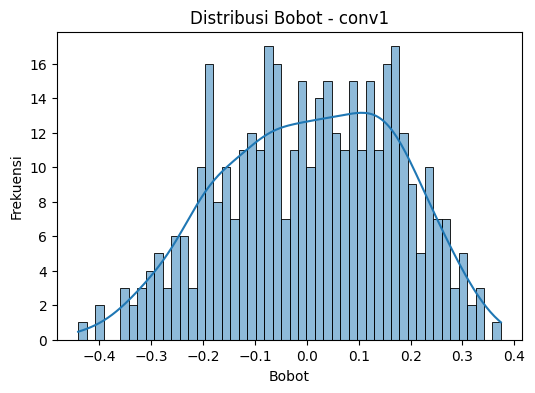

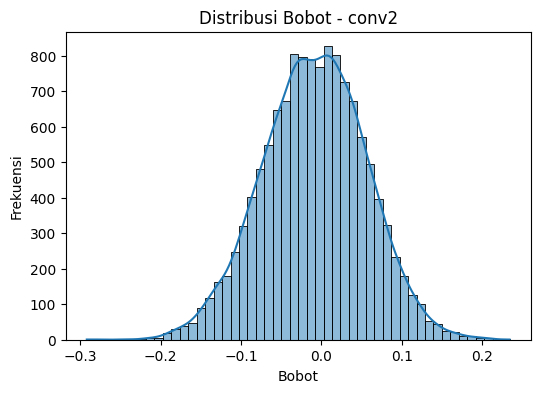

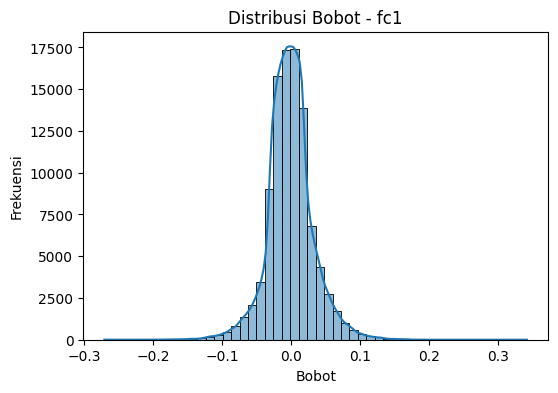

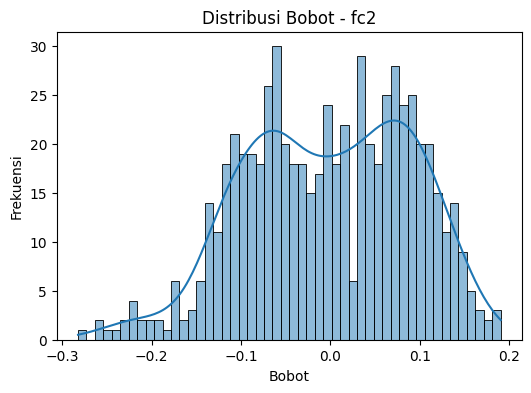

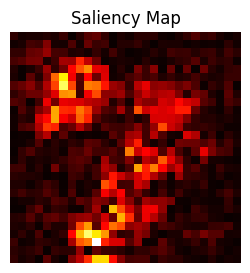


Visualisasi Hasil: Kernel Size 5, Pooling max, Epochs 50, Optimizer adam


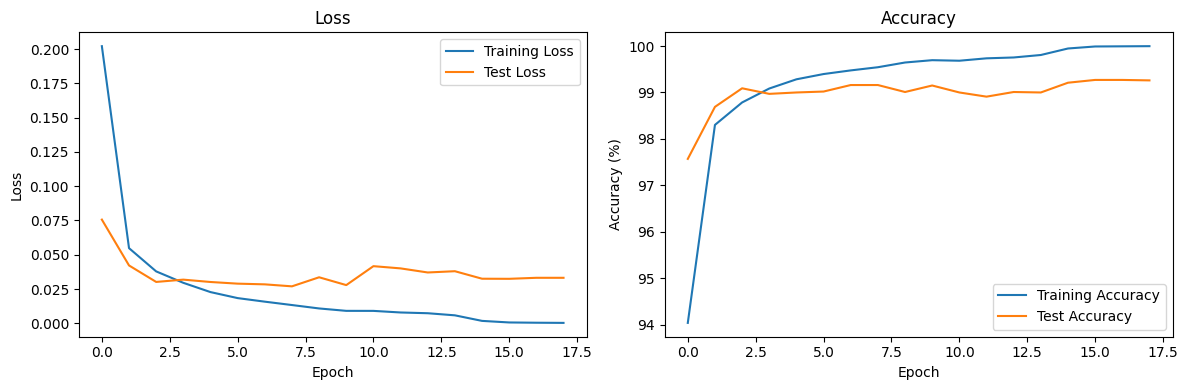

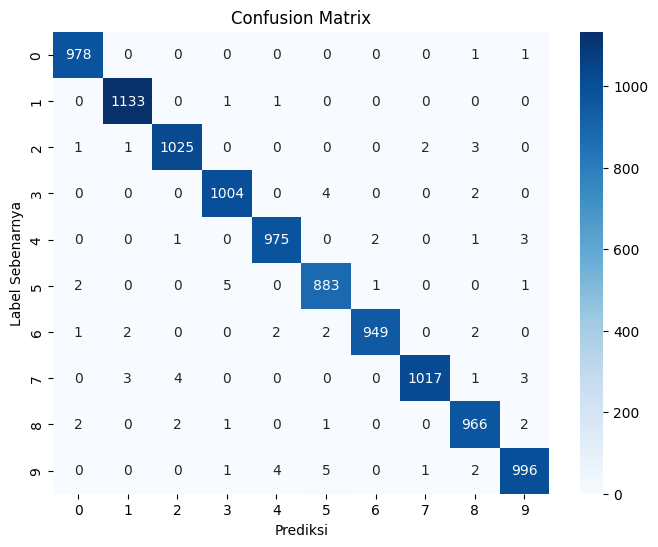

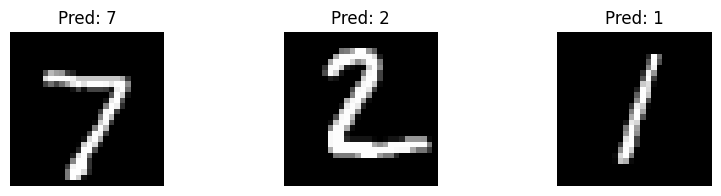

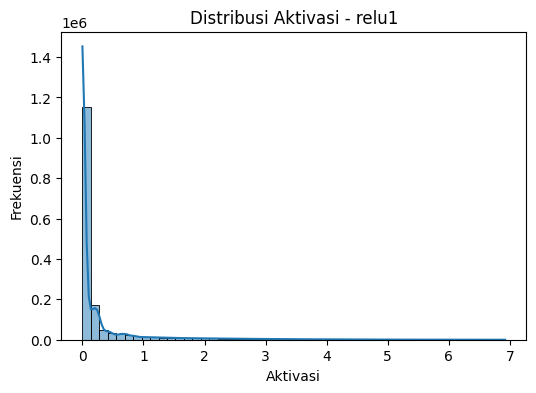

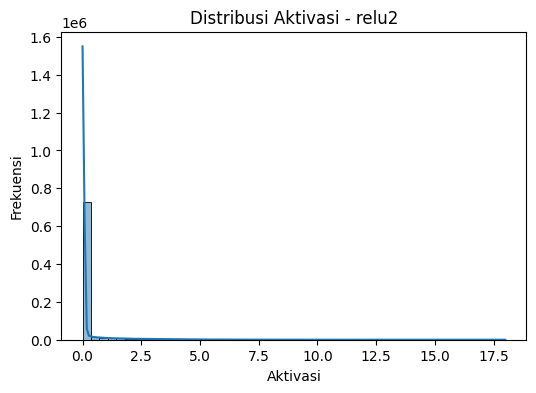

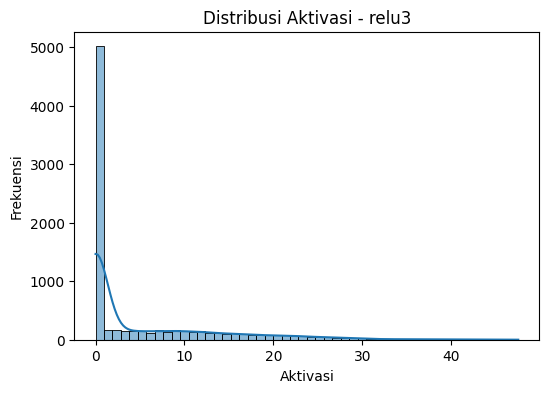

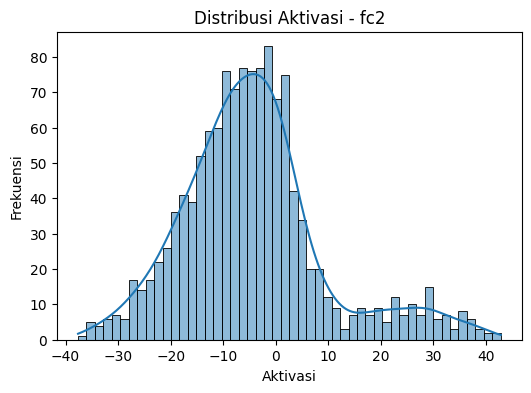

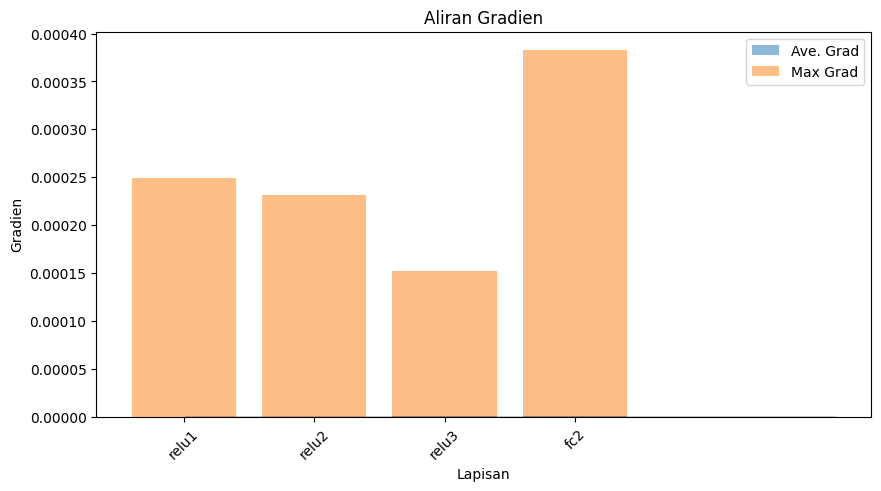

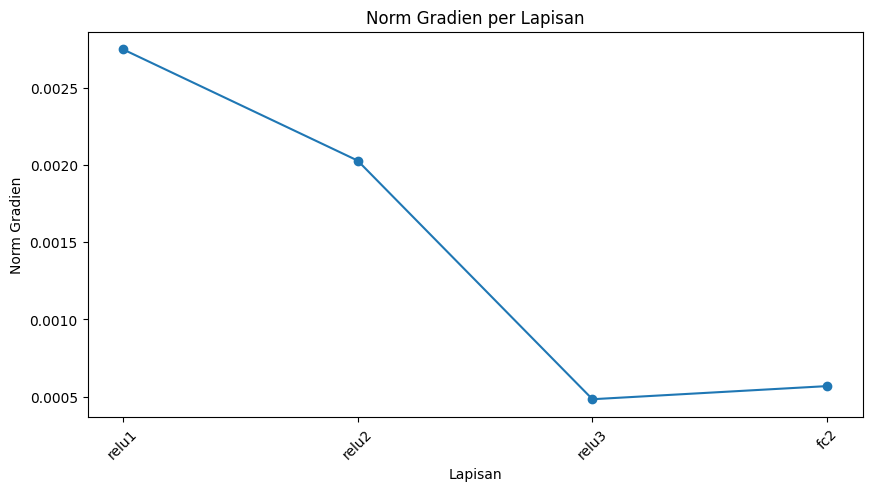

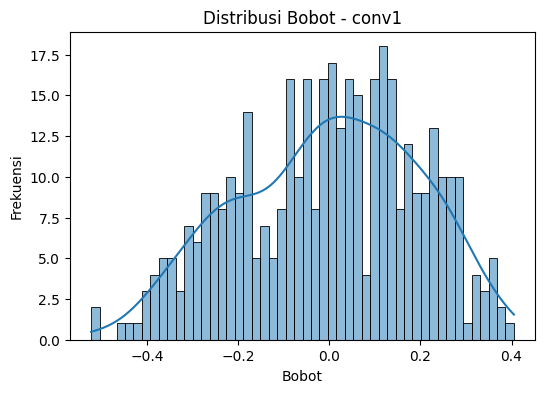

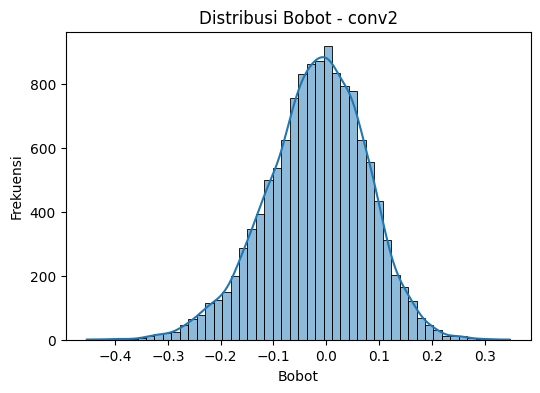

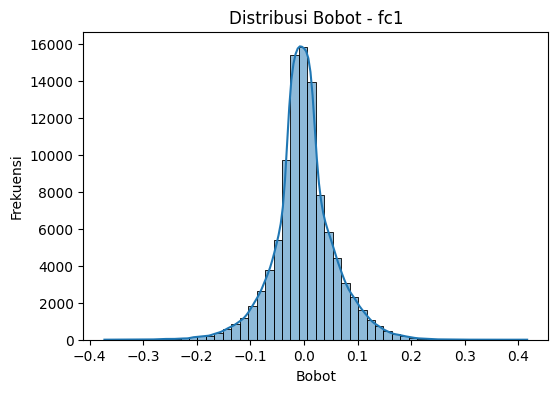

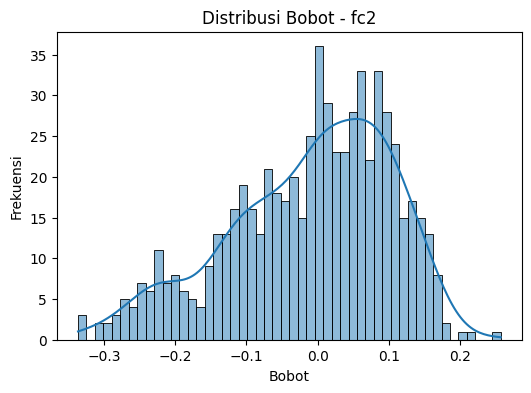

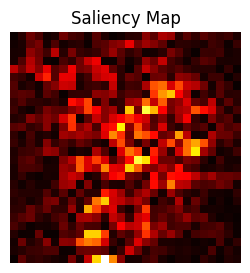


Visualisasi Hasil: Kernel Size 5, Pooling max, Epochs 100, Optimizer adam


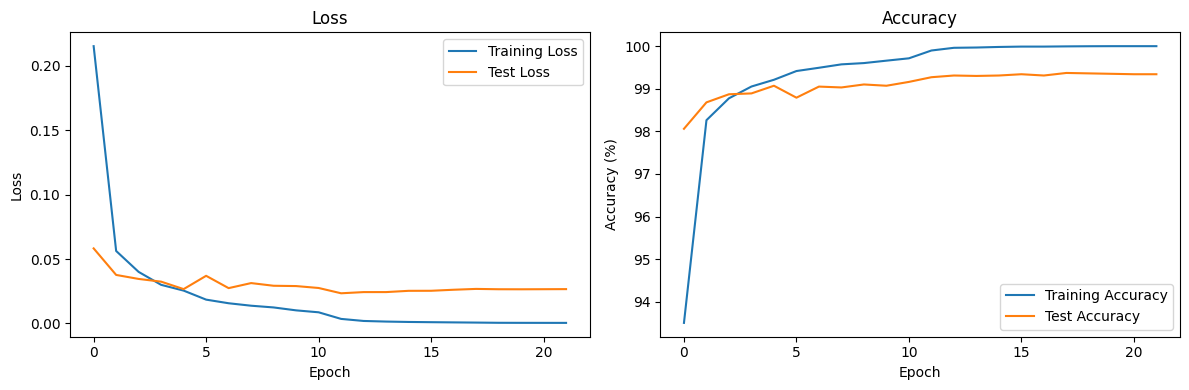

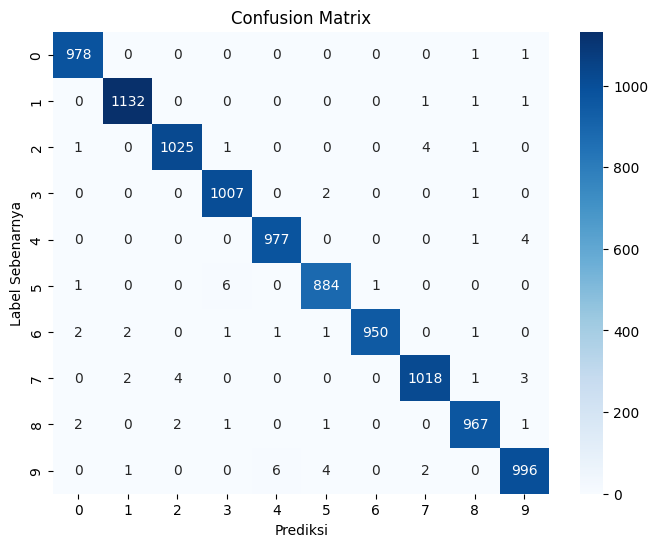

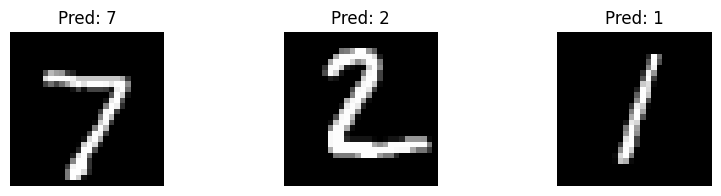

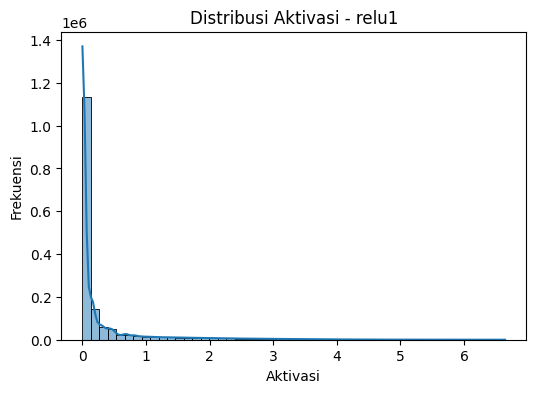

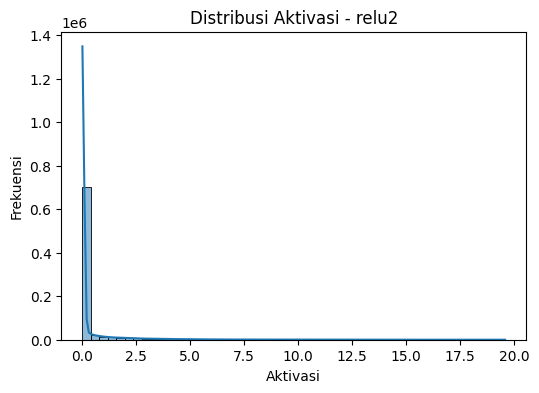

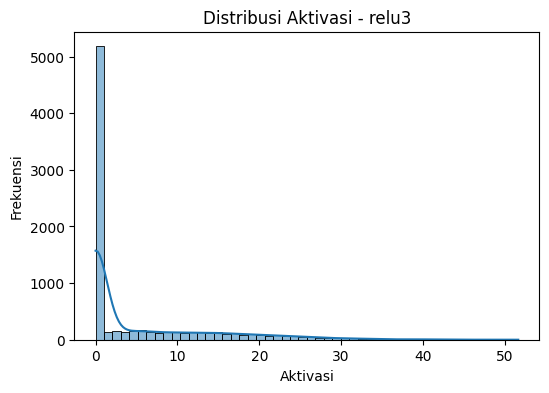

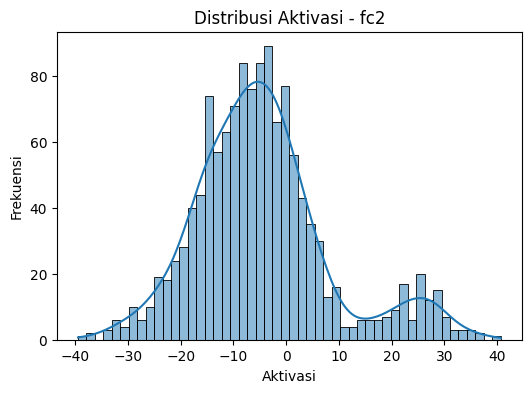

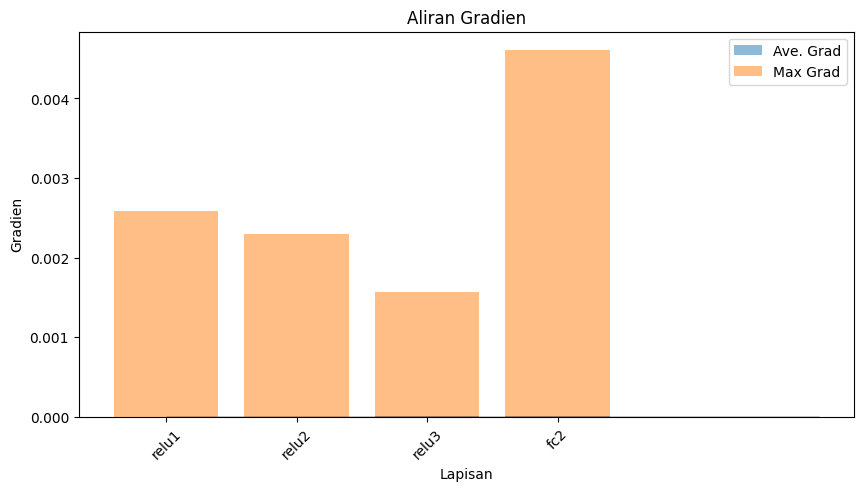

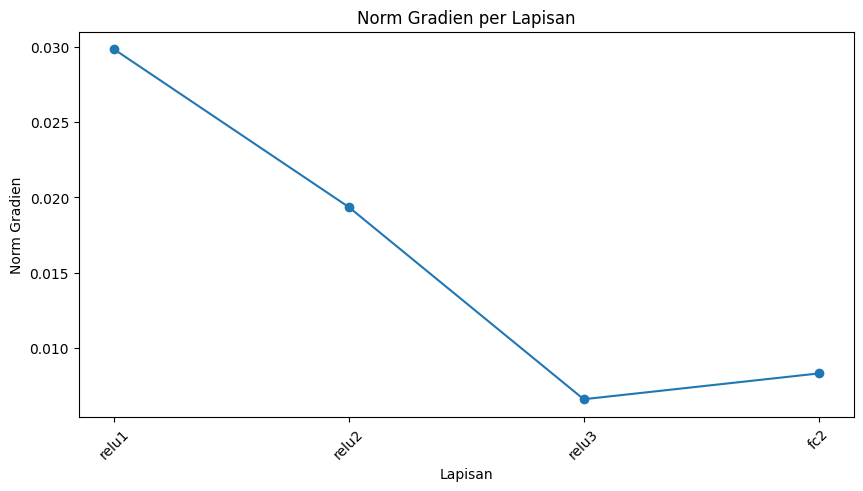

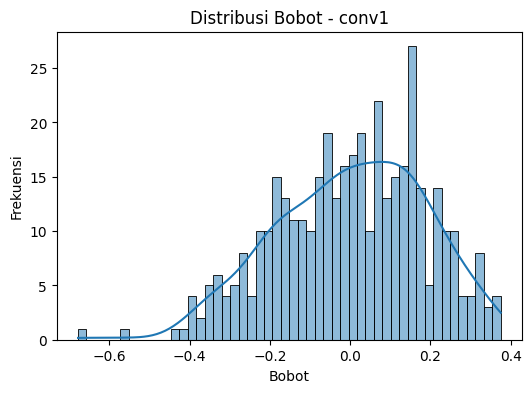

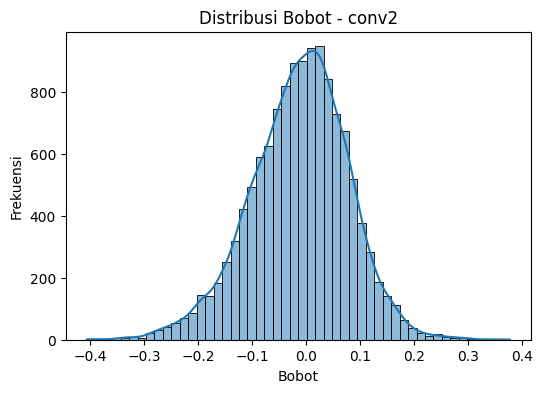

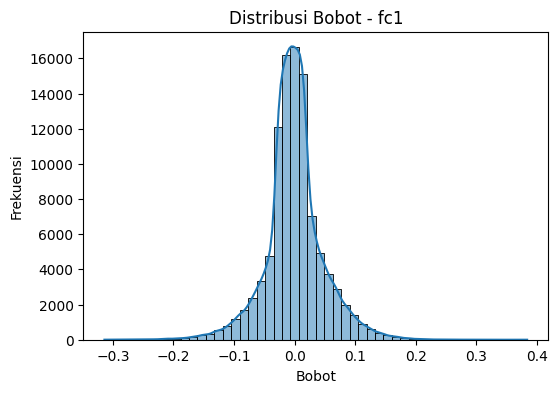

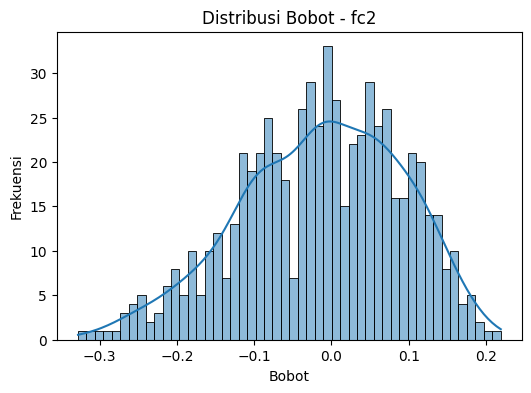

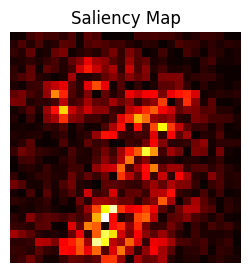


Visualisasi Hasil: Kernel Size 5, Pooling avg, Epochs 5, Optimizer adam


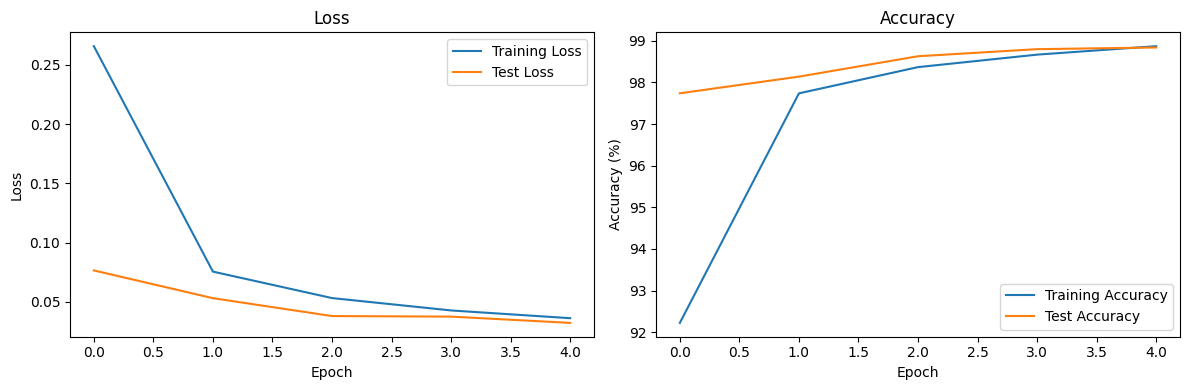

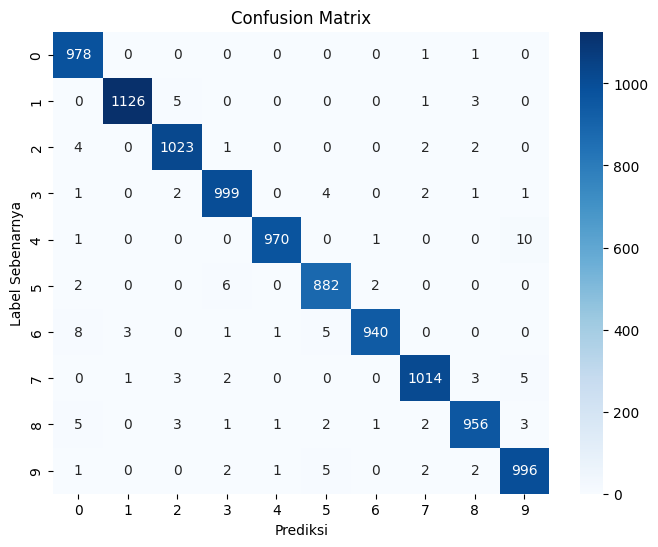

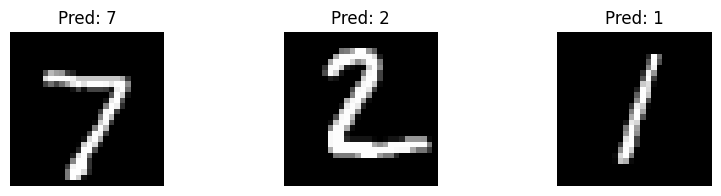

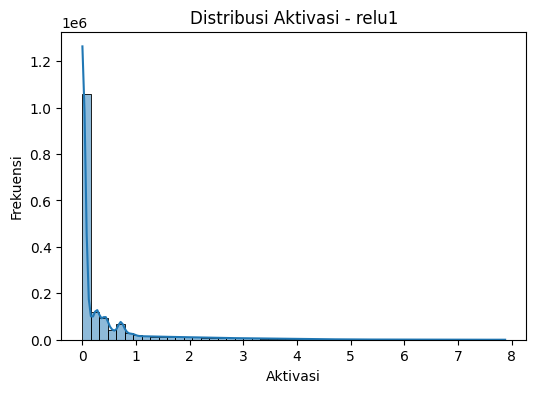

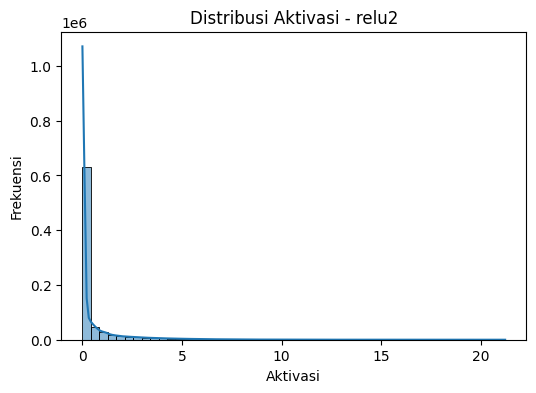

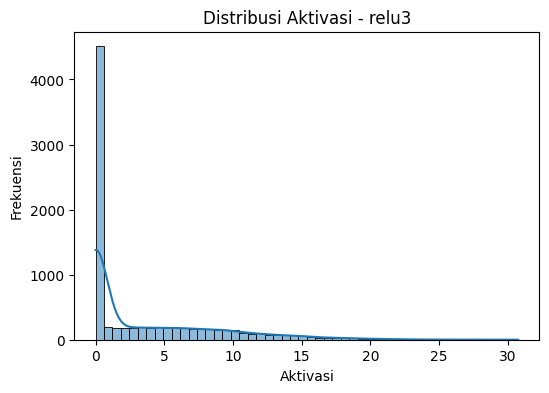

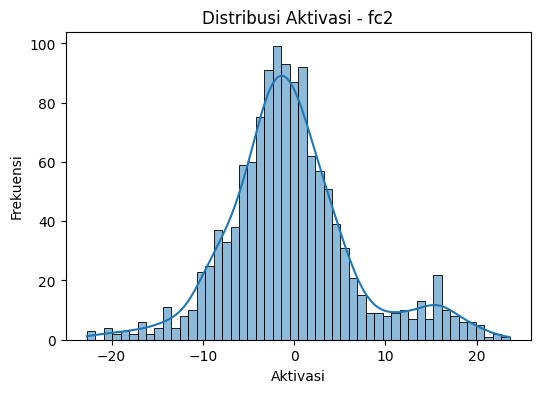

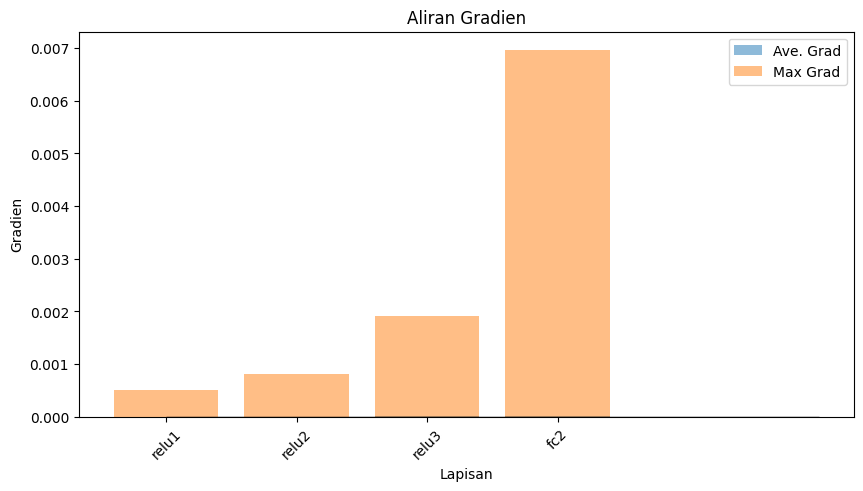

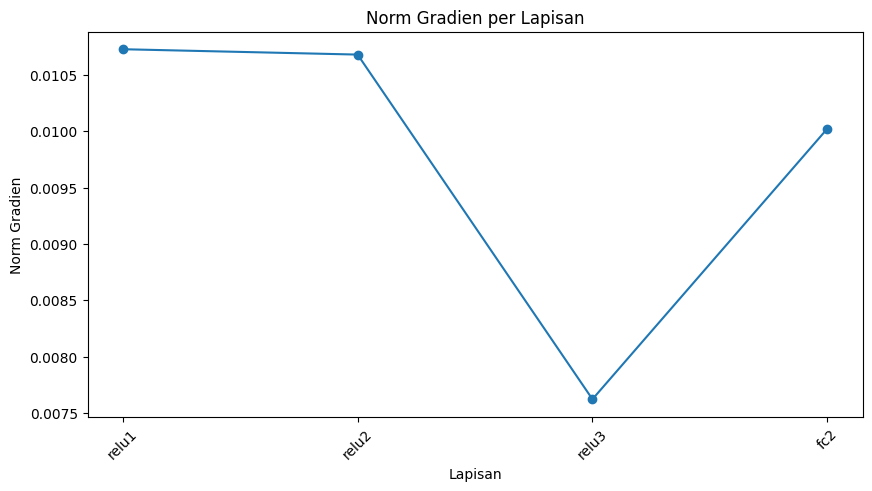

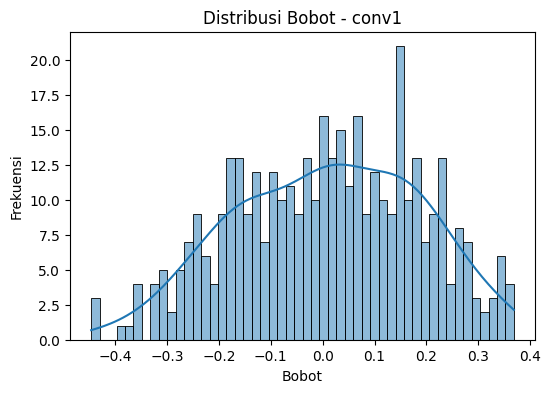

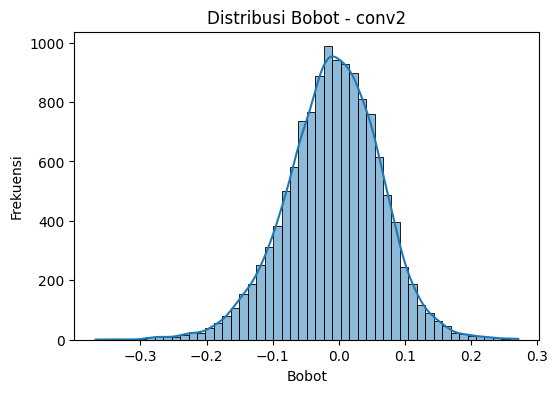

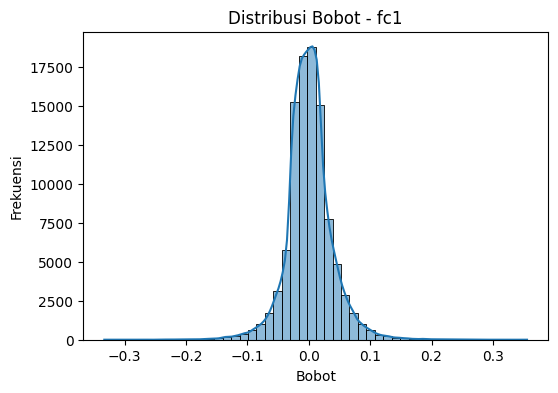

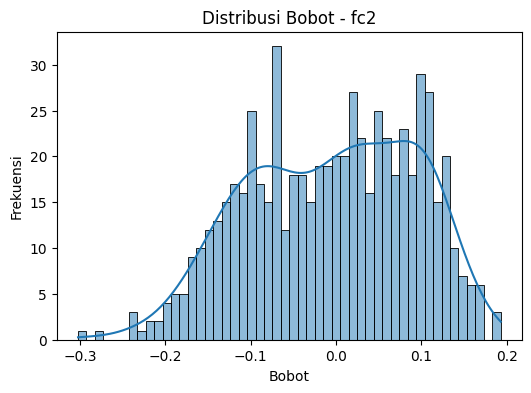

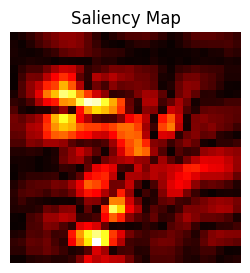


Visualisasi Hasil: Kernel Size 5, Pooling avg, Epochs 50, Optimizer adam


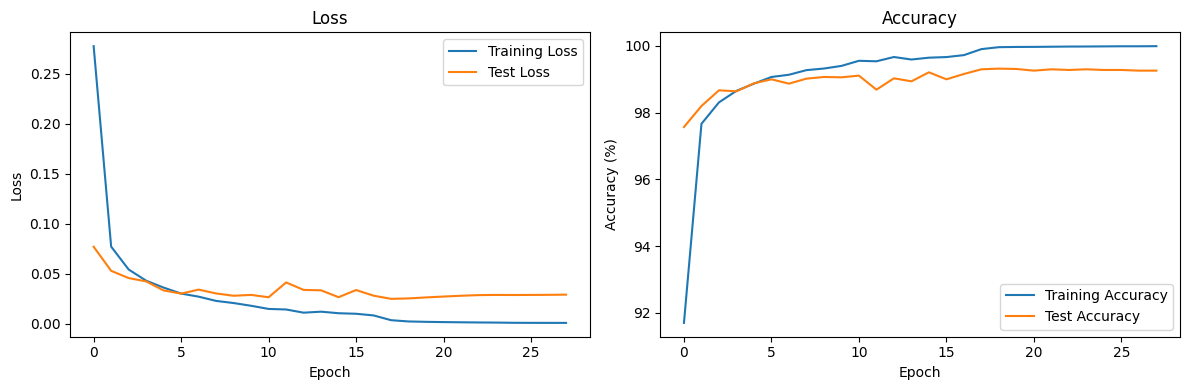

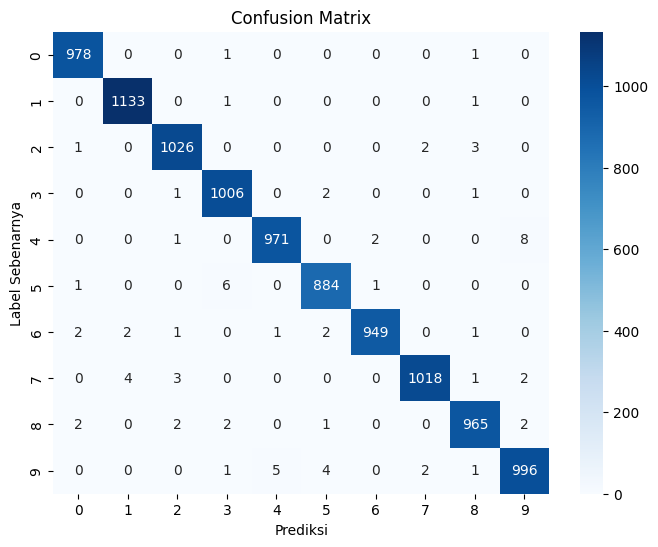

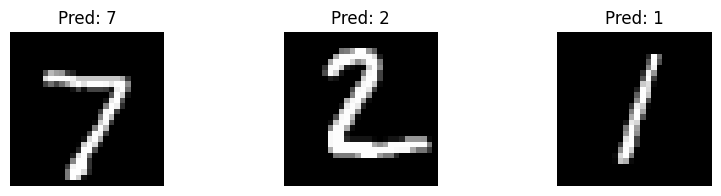

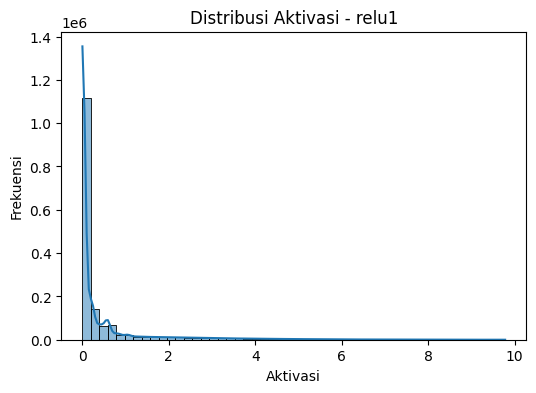

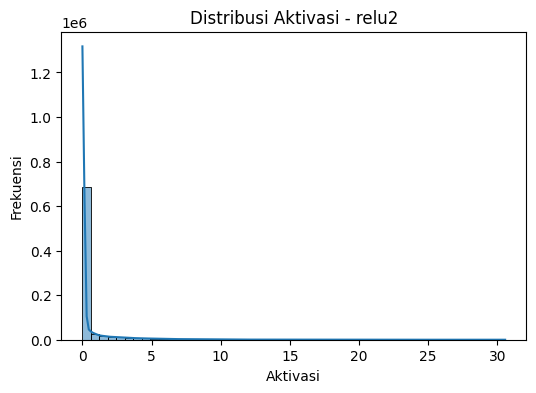

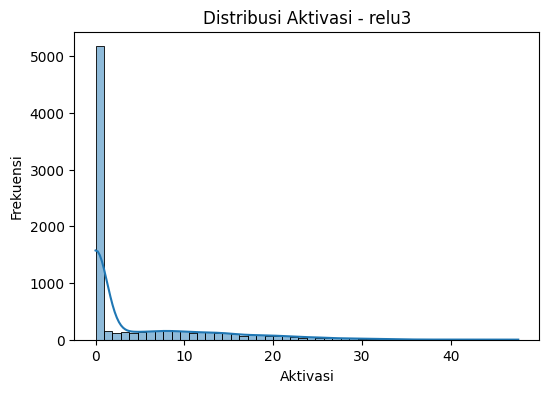

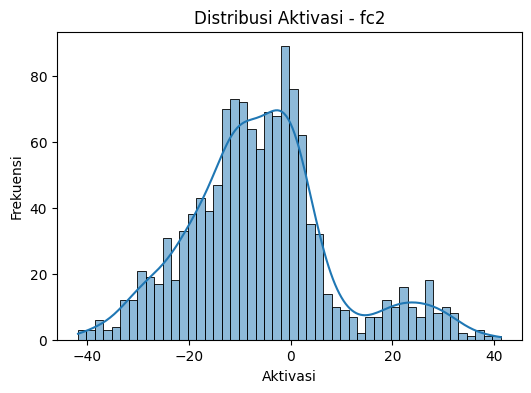

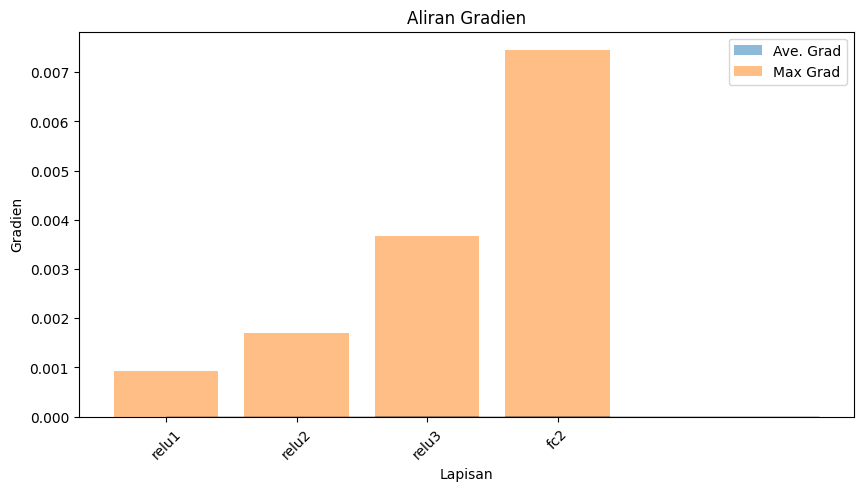

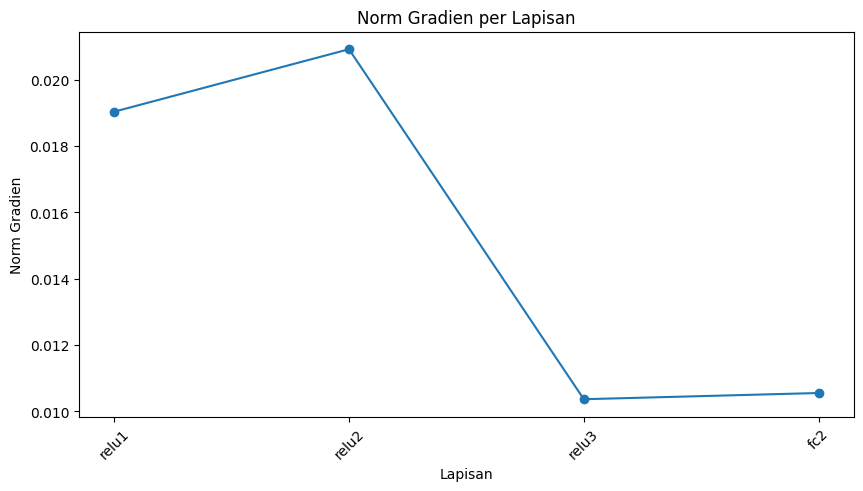

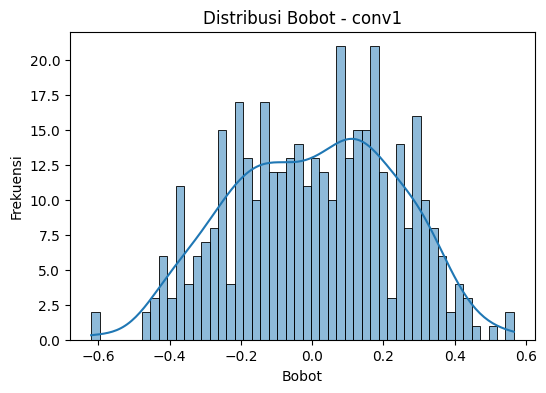

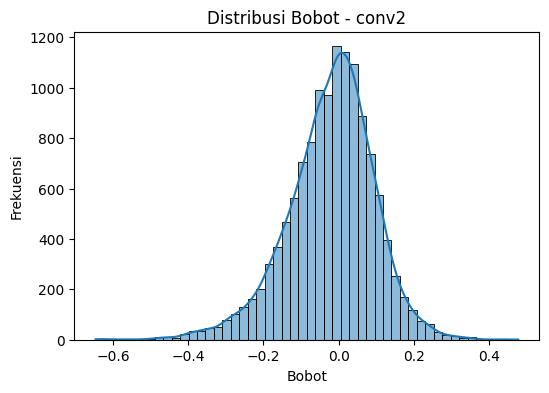

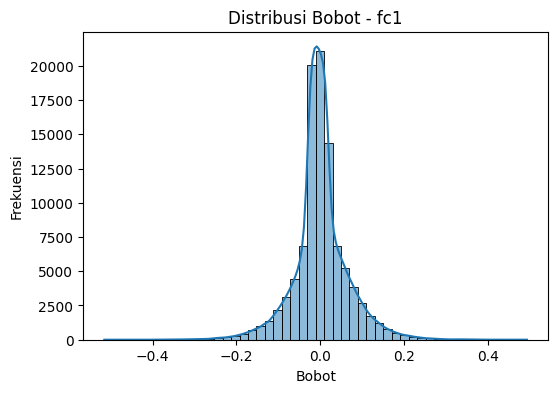

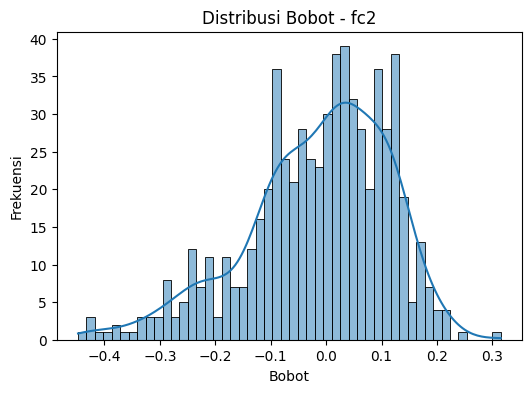

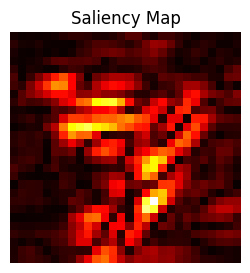


Visualisasi Hasil: Kernel Size 5, Pooling avg, Epochs 100, Optimizer adam


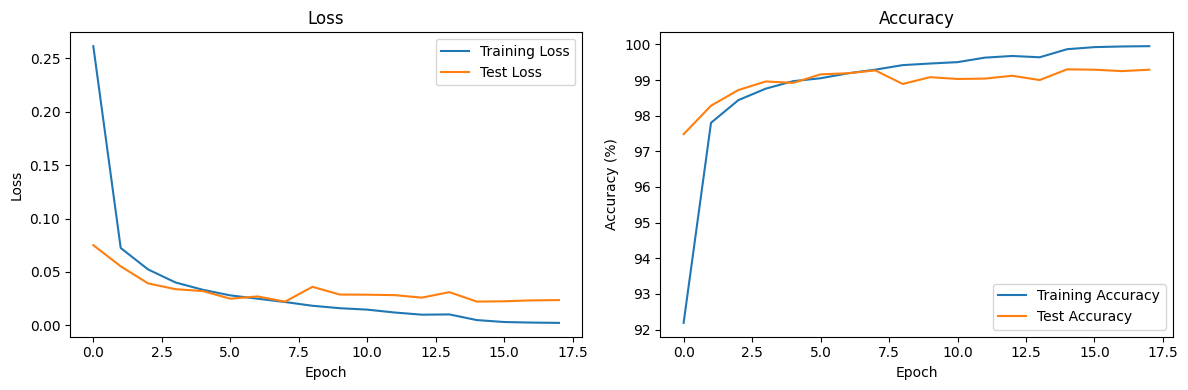

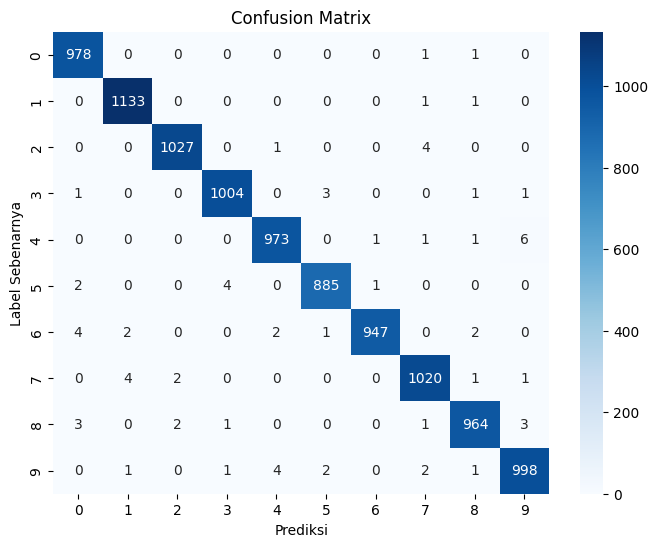

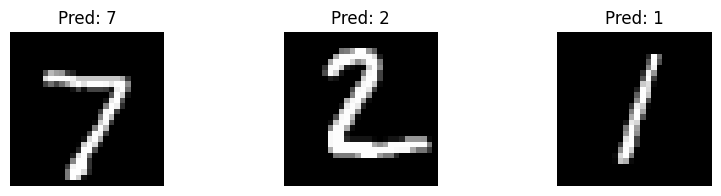

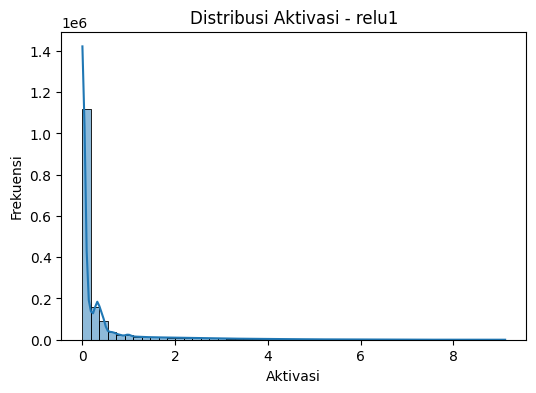

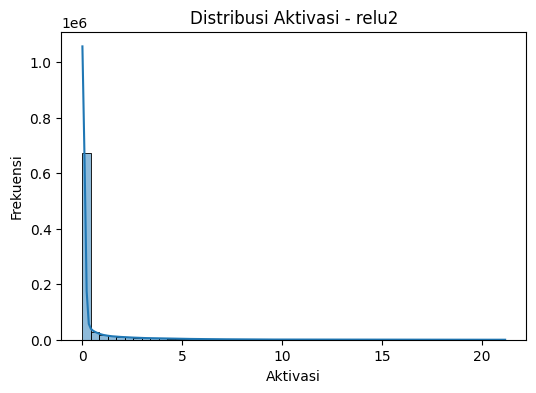

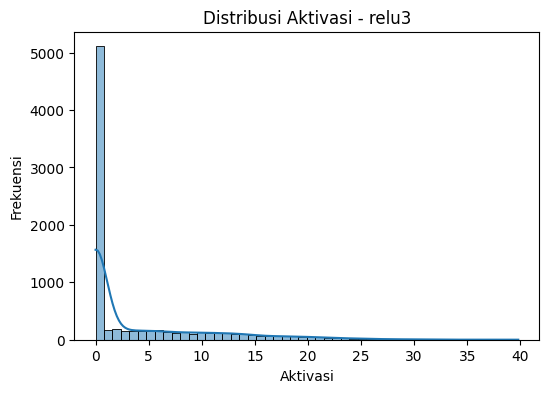

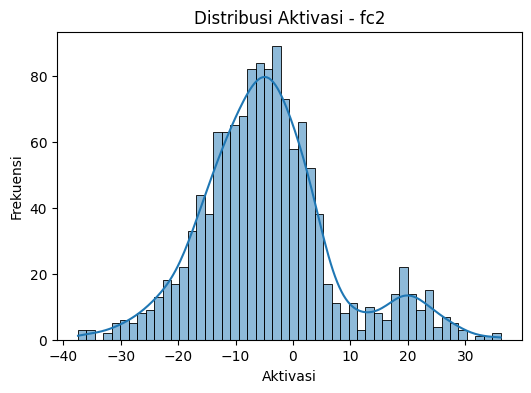

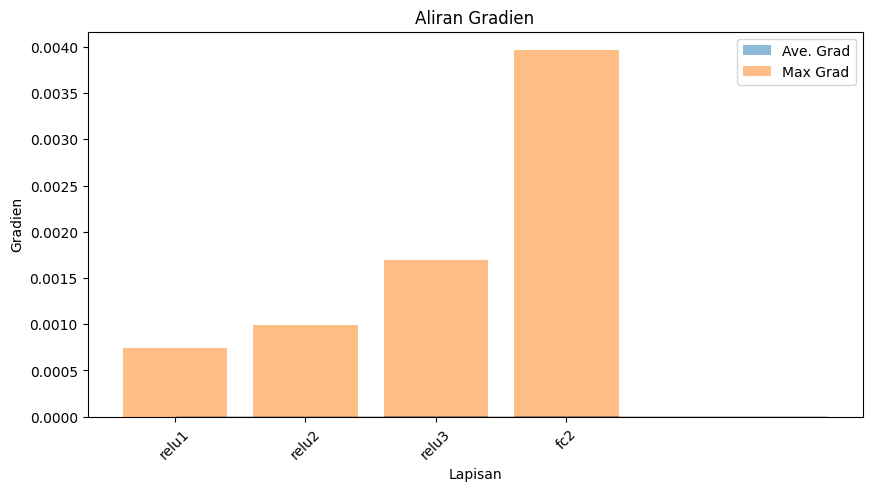

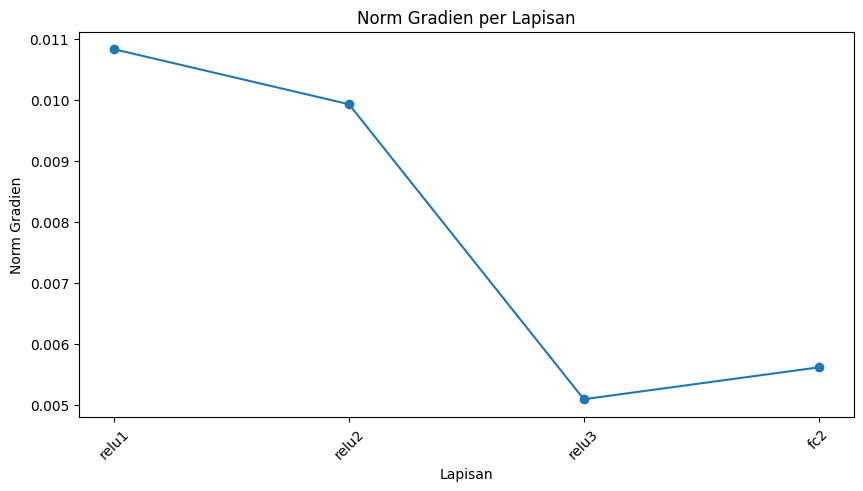

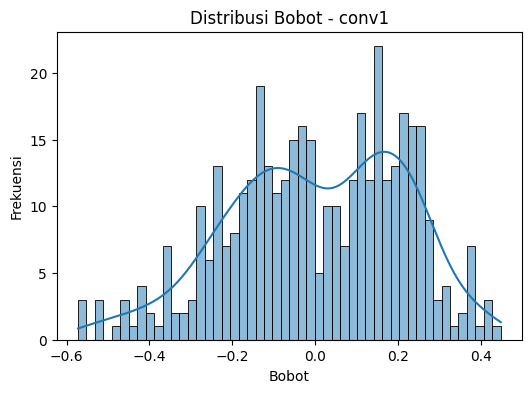

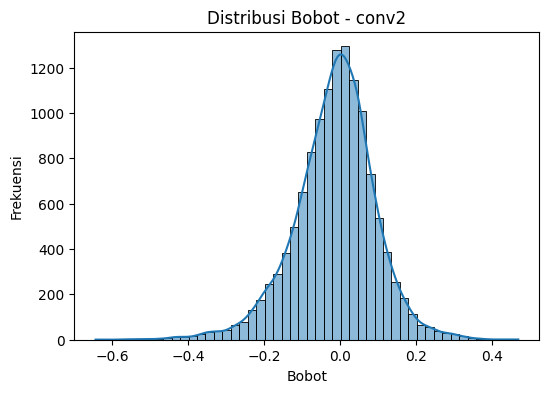

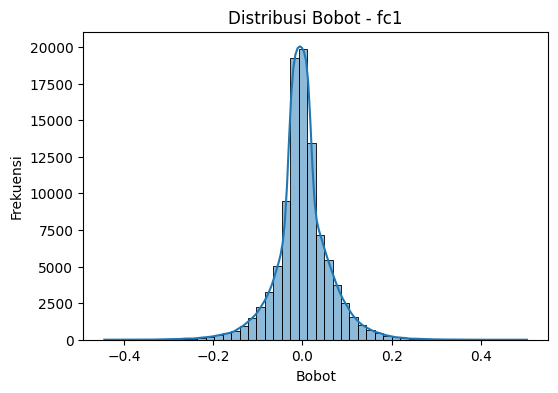

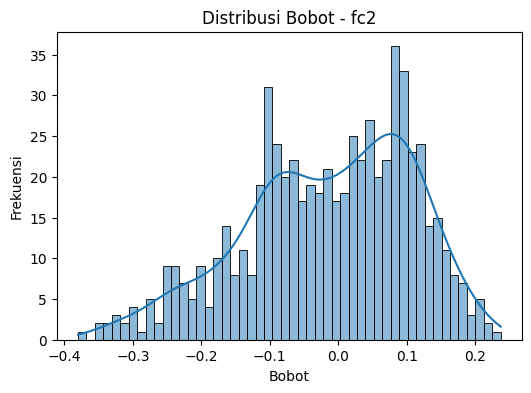

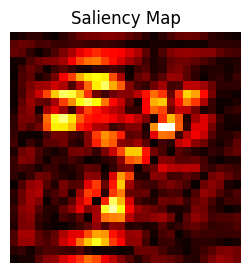

In [ ]:
# ==========================
# 7. Visualisasi Hasil Eksperimen
# ==========================
activations = collections.defaultdict(list)
gradients = collections.defaultdict(list)

def get_activation(name, activations): # tambahkan activations sebagai argumen
    def hook(model, input, output):
        activations[name].append(output.detach())
    return hook

def get_gradient(name, gradients): # tambahkan gradients sebagai argumen
    def hook(model, grad_input, grad_output):
        gradients[name].append(grad_output[0].detach())
    return hook


for (ks, pool, ep, opt_name), result in results.items():
    print(f"\nVisualisasi Hasil: Kernel Size {ks}, Pooling {pool}, Epochs {ep}, Optimizer {opt_name}")

    # Plot Loss dan Akurasi
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(result['train_losses'], label='Training Loss')
    plt.plot(result['test_losses'], label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['train_accuracies'], label='Training Accuracy')
    plt.plot(result['test_accuracies'], label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Evaluasi model dan plot confusion matrix
    model = result['model']
    all_labels, all_preds = evaluate_model(model, test_loader, device)
    plot_confusion_matrix(all_labels, all_preds)

    # Visualisasi Prediksi
    show_predictions(model, test_loader, device)

    # Visualisasi Aktivasi, Gradien, Bobot
    #visualisasi dilakukan setelah semua training selesai, simpan data activation dan gradient hanya setelah training selesai
    activations = collections.defaultdict(list)
    gradients = collections.defaultdict(list)


    for name, layer in model.named_modules():
        if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            layer.register_forward_hook(get_activation(name, activations))
            layer.register_backward_hook(get_gradient(name, gradients))

    dataiter = iter(test_loader) # get iterator dari test loader
    images, labels = next(dataiter) # ambil data dari test loader

    images = images.to(device) # pindahkan gambar ke device
    outputs = model(images) #lakukan forward pass
    model.zero_grad() #zero kan gradient
    loss = criterion(outputs, labels.to(device)) #hitung loss untuk di backward
    loss.backward() #lakukan backward pass



    layers_to_plot = ['relu1', 'relu2', 'relu3', 'fc2']
    for layer in layers_to_plot:
        plot_activation_distribution(activations, layer)

    plot_gradient_flow(gradients, layers_to_plot)
    plot_gradient_norm(gradients, layers_to_plot)

    layers_to_plot = ['conv1', 'conv2', 'fc1', 'fc2']
    plot_weight_distribution(model,layers_to_plot)

    examples = 1
    with torch.no_grad():
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
    for i in range(examples):
      plot_saliency_map(model, images[i], labels[i].item(), device)


    del model #hapus model yang sudah di visualisasikan
    torch.cuda.empty_cache()